In [1]:
import re
import time
import requests
import math as math
from bs4 import BeautifulSoup
from datetime import datetime
from collections import Counter

# garbage collector
import gc
# supress unnecessary warnings so the notebook looks clean
import warnings
warnings.filterwarnings('ignore')

# import libraries to quickly analyze data
import numpy as np
import pandas as pd
from scipy.fftpack import fft
pd.set_option('precision', 4)

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# loading data
train_1 = pd.read_csv('datasets/train_1.csv')
key_1 = pd.read_csv('datasets/key_1.csv')
ss = pd.read_csv("datasets/sample_submission_1.csv")

In [3]:
# memory usage
print('Memory consumption for train data, Mb: {:.2f}'.format(train_1.memory_usage().sum()/2**20))
print('Memory consumption for key data, Mb: {:.2f}'.format(key_1.memory_usage().sum()/2**20))

Memory consumption for train data, Mb: 609.82
Memory consumption for key data, Mb: 132.81


As we can see train data frame is having less number of page details than number of mappings between keys and page. First and last rows of train and key data frame.

In [4]:
# check missing values
print("Number of missing values in train data:", train_1.isnull().sum().sum())
print("Number of missing values in key data:", key_1.isnull().sum().sum())

Number of missing values in train data: 6192931
Number of missing values in key data: 0


In [5]:
empty_sample = train_1[train_1.isnull().any(axis=1)]
print("Number of records contain 1+ null: ", empty_sample.shape[0], "\n")
empty_sample.iloc[np.r_[0:3, len(empty_sample)-3:len(empty_sample)]]

Number of records contain 1+ null:  27786 



,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
6,91Days_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,7.0,33.0,8.0,11.0,4.0,15.0,6.0,8.0,6.0
10,ASTRO_zh.wikipedia.org_all-access_spider,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,11.0,38.0,85.0,79.0,30.0,14.0,10.0,38.0,12.0,51.0
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145062,Francisco_el_matemático_(serie_de_televisión_d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


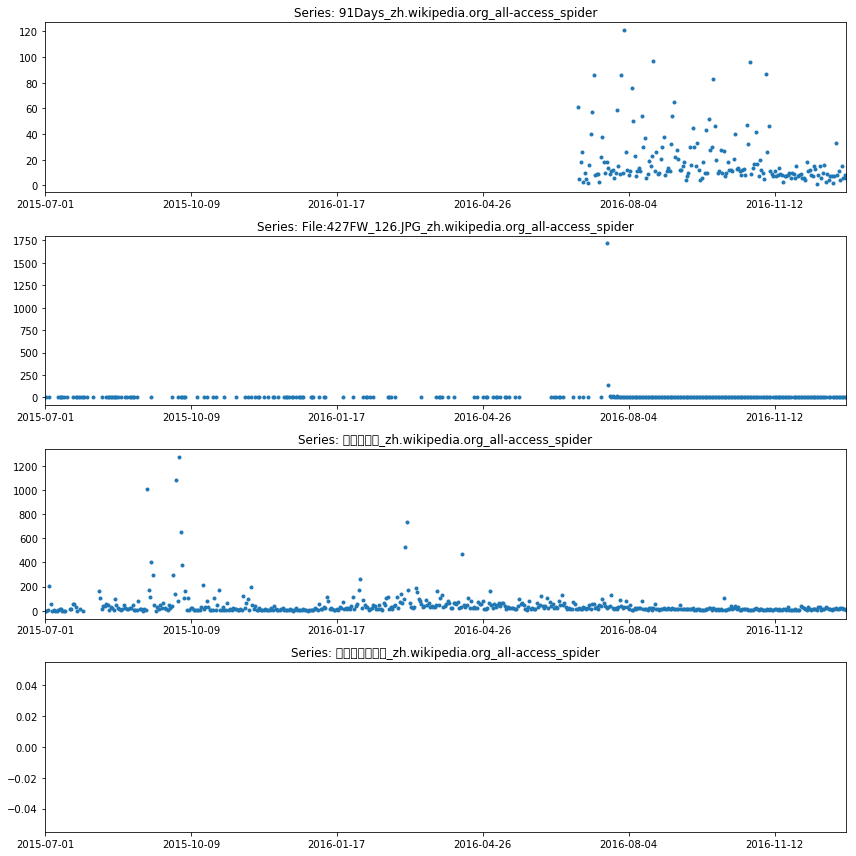

In [6]:
# plot 3 the time series
def plot_time_series(df, row_num, start_col =1, ax=None):
    if ax is None:
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        
    series_title = df.iloc[row_num, 0]
    sample_series = df.iloc[row_num, start_col:]
    sample_series.plot(style=".", ax=ax)
    ax.set_title("Series: %s" % series_title)

fig, axs  = plt.subplots(4,1,figsize=(12,12))
plot_time_series(empty_sample, 1, ax=axs[0])
plot_time_series(empty_sample, 10, ax=axs[1])
plot_time_series(empty_sample, 100, ax=axs[2])
plot_time_series(empty_sample, 1005, ax=axs[3])

plt.tight_layout()

## Data Analysis

### 1. General / Group trends

I'm going to fill the NaN values with 0 since the dataset does not distinguish between 0 and missing. We'll have to deal with these later.

In [7]:
train_df1 = train_1.copy()
train_df1 = train_df1.fillna(0).sample(15000)

# reshape df to "flatten" form
train_flattened = pd.melt(train_df1, id_vars='Page', var_name='date', value_name='traffic')

# see new shape and check it
print("Shape of flattened train data:", train_flattened.shape)
assert train_flattened.shape[0] == (train_df1.shape[1]-1)*train_df1.shape[0], 'shit happened :('

# initial types/consumption
print(train_flattened.dtypes)

Shape of flattened train data: (8250000, 3)
Page        object
date        object
traffic    float64
dtype: object


In [8]:
# add new column to distinquish between 0 and NaN in traffic
train_flattened['traffic_is_missing'] = train_flattened.traffic.isnull().astype(np.bool)

# now fillna as 0 and downcast dtype to np.int32, since max_value = 67264258
train_flattened.traffic.fillna(0, inplace=True)
train_flattened.traffic = train_flattened.traffic.astype(np.int32)

# convert datetime to datetime
train_flattened.date = pd.to_datetime(train_flattened.date, format="%Y-%m-%d")
gc.collect()

# optimized types/consumption
print(train_flattened.dtypes)
print('Memory consumption, Mb: {:.2f}'.format(train_flattened.memory_usage().sum()/2**20))

Page                          object
date                  datetime64[ns]
traffic                        int32
traffic_is_missing              bool
dtype: object
Memory consumption, Mb: 165.22


In [9]:
# create small dictionary df from 'Page' column
page_dict = pd.DataFrame({'Page': train_flattened.Page.unique()})

# split it to add some features
page_dict['agent_type'] = page_dict.Page.str.rsplit('_').str.get(-1)
page_dict['access_type'] = page_dict.Page.str.rsplit('_').str.get(-2)
page_dict['project'] = page_dict.Page.str.rsplit('_').str.get(-3)
# dirty hacking to get it :)
page_dict['page_name'] = page_dict.apply(
    lambda r: r['Page'][:-int(len(r['agent_type'])+len(r['access_type'])+len(r['project'])+3)], axis=1)

# add country
page_dict['source'] = page_dict.project.str.split('.').str.get(0).map(
    {'en':'English', 'ja':'Japanese', 
     'de':'German', 'fr':'France', 'zh':'Chinese',
    'ru':'Russian', 'es':'Spanish'}
).fillna('Other-Media')

# change dtypes to 'category'
for c in page_dict.columns:
    page_dict[c] = page_dict[c].astype('category')

# set index and see sample output
page_dict.set_index('Page', inplace=True)
page_dict.head()

,agent_type,access_type,project,page_name,source
Page,,,,,
MediaWiki:Common.js/NormalizeCharWidth.js_ja.wikipedia.org_desktop_all-agents,all-agents,desktop,ja.wikipedia.org,MediaWiki:Common.js/NormalizeCharWidth.js,Japanese
尹均相_zh.wikipedia.org_desktop_all-agents,all-agents,desktop,zh.wikipedia.org,尹均相,Chinese
Oussama_ben_Laden_fr.wikipedia.org_all-access_all-agents,all-agents,all-access,fr.wikipedia.org,Oussama_ben_Laden,France
100-Meter-Lauf_de.wikipedia.org_mobile-web_all-agents,all-agents,mobile-web,de.wikipedia.org,100-Meter-Lauf,German
Spezial:Abmelden_de.wikipedia.org_desktop_all-agents,all-agents,desktop,de.wikipedia.org,Spezial:Abmelden,German


In [10]:
# check unique values in categories:
print('User-agent')
print(page_dict.agent_type.value_counts())

print('\nProjects')
print(page_dict.project.value_counts())

print('\nAccess')
print(page_dict.access_type.value_counts())

User-agent
all-agents    11428
spider         3572
Name: agent_type, dtype: int64

Projects
en.wikipedia.org         2442
ja.wikipedia.org         2144
de.wikipedia.org         1976
zh.wikipedia.org         1785
fr.wikipedia.org         1755
ru.wikipedia.org         1546
es.wikipedia.org         1463
commons.wikimedia.org    1080
www.mediawiki.org         809
Name: project, dtype: int64

Access
all-access    7747
mobile-web    3710
desktop       3543
Name: access_type, dtype: int64


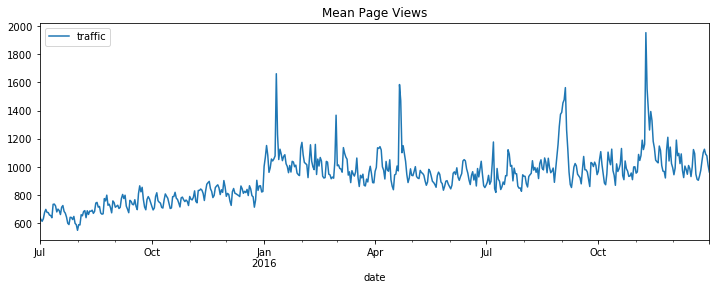

In [11]:
# let's see general trend (averaged over pages by day)
train_flattened.groupby('date').aggregate({'traffic': 'mean'}).plot(
    figsize=(12,4), 
    title='Mean Page Views')

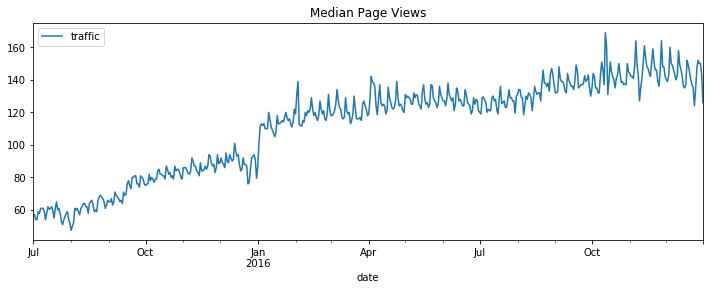

In [12]:
# let's see general trend (and median-based, more robust)
train_flattened.groupby('date').aggregate({'traffic': 'median'}).plot(
    figsize=(12,4), 
    title='Median Page Views')

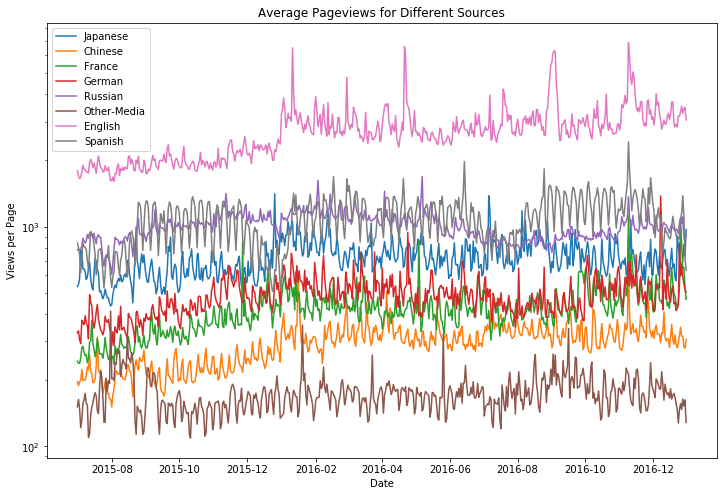

In [13]:
# grouped plots, by source, mean pageviews (log-scaled for a better comparison)
gc.collect()

train_flattened['source'] = train_flattened.Page.map(page_dict.source)
grouped = train_flattened.groupby(['source', 'date']).aggregate({'traffic': 'mean'}).astype(np.float16)

fig = plt.figure(1, figsize=(12,8))
plt.ylabel('Views per Page')
plt.xlabel('Date')
plt.title('Average Pageviews for Different Sources')

for s in page_dict.source.unique():
    data = grouped.iloc[grouped.index.get_level_values('source') == s].reset_index(level=0, drop=True)
    plt.plot(data.index, data.traffic, label=s)

plt.legend()
plt.yscale('log') # logarithmic scale

pass
del train_df1, train_flattened

It seems like in English and Russia August was hot.

### 2. High level insight on wikipedia web traffic

In [14]:
train_df2 = train_1.copy()
key_df2 = key_1.copy()

train_df2 = train_df2.sample(15000)
key_df2 = key_df2.sample(850000)

In [15]:
print(train_1[:3].append(train_1[-3:], ignore_index=True))

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...         NaN         NaN   
4  Hasta_el_último_hombre_es.wikipedia.org_all-ac...         NaN         NaN   
5  Francisco_el_matemático_(serie_de_televisión_d...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN     

In [16]:
print(key_1[:3].append(key_1[-3:], ignore_index=True))

                                                Page            Id
0  !vote_en.wikipedia.org_all-access_all-agents_2...  bf4edcf969af
1  !vote_en.wikipedia.org_all-access_all-agents_2...  929ed2bf52b9
2  !vote_en.wikipedia.org_all-access_all-agents_2...  ff29d0f51d5c
3  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  b0624c909f4c
4  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  24a1dfb06c10
5  龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...  add681d54216


Each article name has the following format: 'name_project_access_agent' . That would be a good idea to separate out all these 4 features to get better understanding of data.

In [17]:
page_details = pd.DataFrame([i.split("_")[-3:] for i in train_df2["Page"]])
page_details.columns = ["project", "access", "agent"]
page_details.describe()

,project,access,agent
count,15000,15000,15000
unique,9,3,2
top,en.wikipedia.org,all-access,all-agents
freq,2535,7611,11393


As we can see there are 9, 3 and 2 unique values for project, access and agent respectively. 

In [18]:
# quick look on these values
project_columns = page_details['project'].unique()
print(list(page_details['project'].unique()))
print()
access_columns = page_details['access'].unique()
print(list(page_details['access'].unique()))
print()
agents_columns = page_details['agent'].unique()
print(list(page_details['agent'].unique()))

['en.wikipedia.org', 'fr.wikipedia.org', 'zh.wikipedia.org', 'de.wikipedia.org', 'commons.wikimedia.org', 'ja.wikipedia.org', 'ru.wikipedia.org', 'www.mediawiki.org', 'es.wikipedia.org']

['all-access', 'desktop', 'mobile-web']

['all-agents', 'spider']


In [19]:
# merge the data
train_df2 = train_df2.merge(page_details, how="inner", left_index=True, right_index=True)

# plot the project wise monthly mean hits
def graph_by(plot_hue, graph_columns):
    train_project_df = train_df2.groupby(plot_hue).sum().T
    train_project_df.index = pd.to_datetime(train_project_df.index)
    train_project_df = train_project_df.groupby(pd.TimeGrouper('M')).mean().dropna()
    train_project_df['month'] = 100*train_project_df.index.year + train_project_df.index.month
    train_project_df = train_project_df.reset_index(drop=True)
    train_project_df = pd.melt(train_project_df, id_vars=['month'], value_vars=graph_columns)
    fig = plt.figure(1,figsize=[12,10])
    ax = sns.pointplot(x="month", y="value", hue=plot_hue, data=train_project_df)
    ax.set(xlabel='Year-Month', ylabel='Mean Hits')

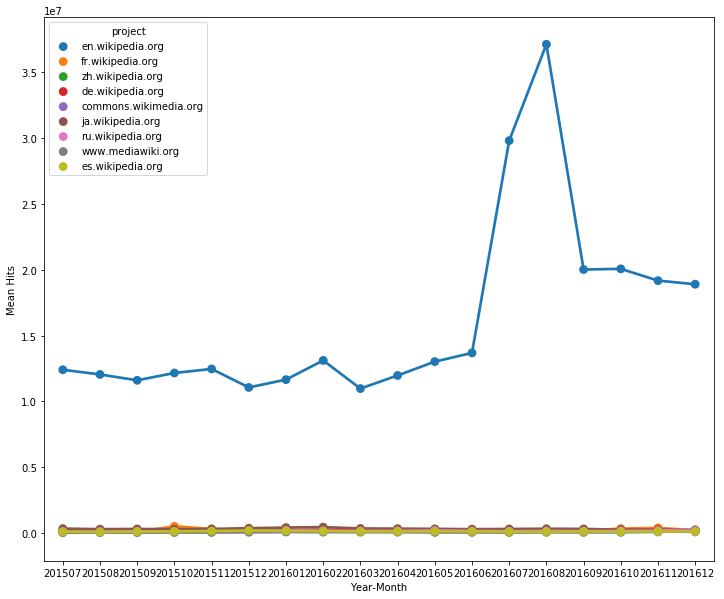

In [20]:
graph_by("project", [x for x in project_columns])

Look, everyone is hitting English Wikipedia project more than any other project. Also, Russian Wikipedia is having same hike near to august 2016 as English Wikipedia.

Now with English project in graph, it is hard to visualise other projects. Why not separate out English project and find some patterns if possible.


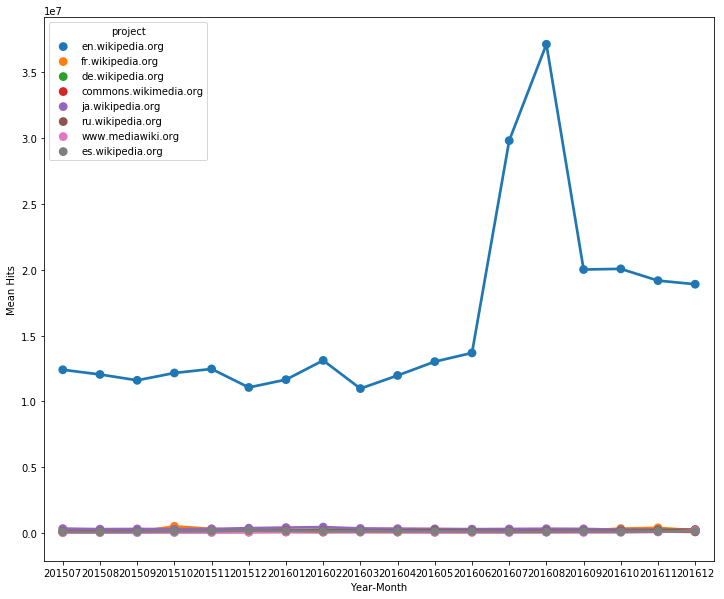

In [21]:
graph_by("project", [x for i,x in enumerate(project_columns) if i!=2])

People rarely use mediawiki, commons or zh.

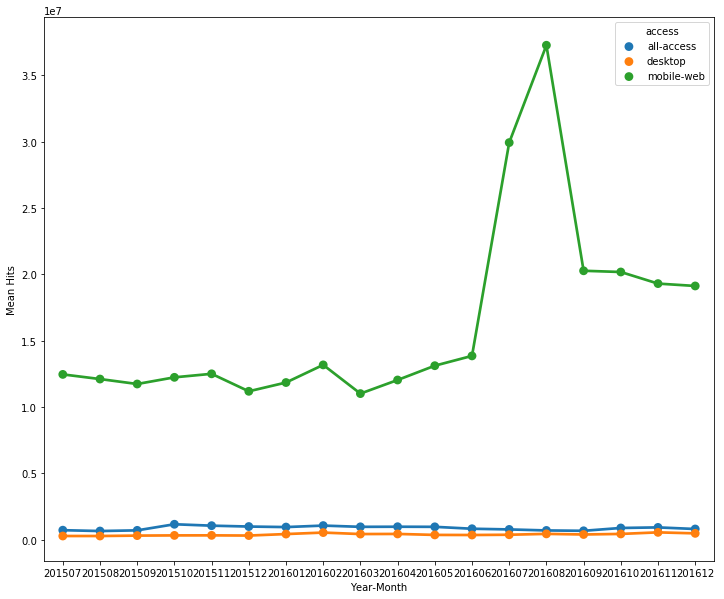

In [22]:
graph_by("access", [x for x in access_columns])

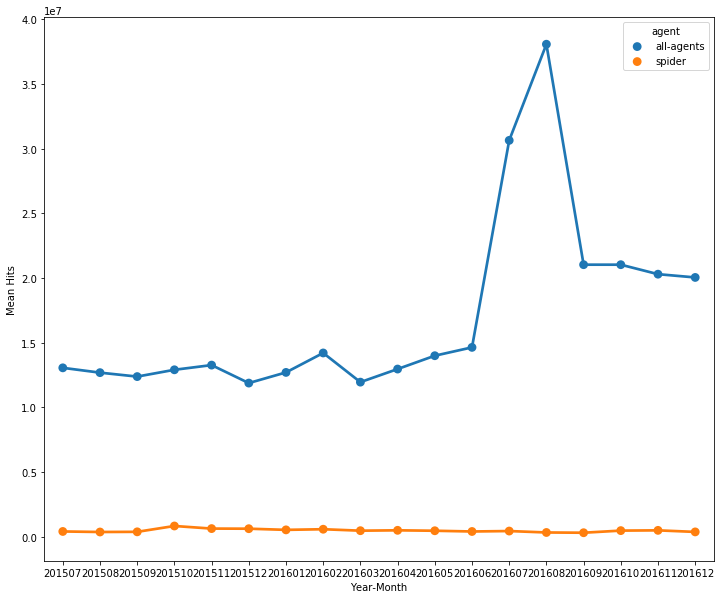

In [23]:
graph_by("agent", [x for x in agents_columns])

We could not get data pattern from above graph. With just two values for agent why not get them plotted in two separate graphs and see how they behave.

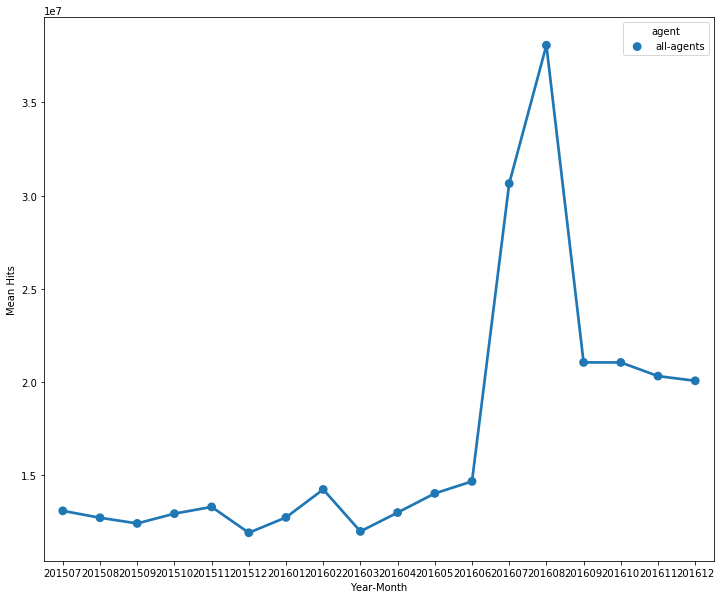

In [24]:
graph_by("agent", agents_columns[0])

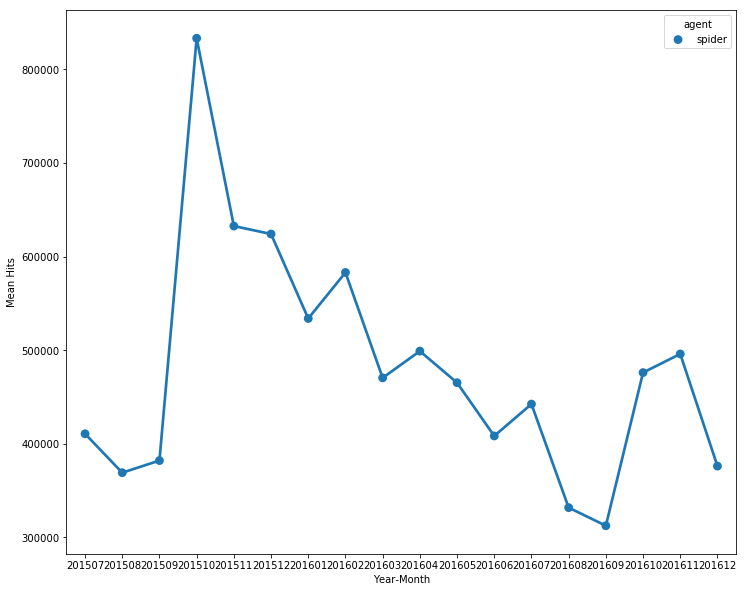

In [25]:
graph_by("agent", agents_columns[1])

del train_df2, key_df2

Lately observed, all-access and all-agents value for access and agents are summation of values for respective attributes. So each value other than all-access contribute in trend for all-access and all values other than all-agents contribute in trend of all-agents.

### 3. Is traffic influenced by page language?

In [26]:
train_df3 = train_1.copy()
train_df3 = train_df3.fillna(0)

for col in train_df3.columns[1:]:
    train_df3[col] = pd.to_numeric(train_df3[col],downcast='integer')

One thing that might be interesting to look is how the different languages used in Wikipedia might affect the dataset. I'll use a simple regular expression to search for the language code in the wikipedia URL. There are also a number of non-wikipedia URLs that will fail the regex search. These are wikimedia pages, so I'll give them the code 'na' since I haven't determined their language. Many of these will be things like images that do not really have a language.

In [27]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train_df3['lang'] = train_df3.Page.map(get_language)
print(Counter(train_df3.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


There are 7 languages plus the media pages. The languages used here are: English, Japanese, German, French, Chinese, Russian, and Spanish. This will make any analysis of the URLs difficult since there are four different writing systems to be dealt with (Latin, Cyrillic, Chinese, and Japanese). Here, I will create dataframes for the different types of entries. I will then calculate the sum of all views. I would note that because the data comes from several different sources, the sum will likely be double counting some of the views.

In [28]:
lang_sets = {}
lang_sets['en'] = train_df3[train_df3.lang=='en'].iloc[:,0:-1]
#lang_sets['ja'] = train_df3[train_df3.lang=='ja'].iloc[:,0:-1]
#lang_sets['de'] = train_df3[train_df3.lang=='de'].iloc[:,0:-1]
#lang_sets['na'] = train_df3[train_df3.lang=='na'].iloc[:,0:-1]
#lang_sets['fr'] = train_df3[train_df3.lang=='fr'].iloc[:,0:-1]
#lang_sets['zh'] = train_df3[train_df3.lang=='zh'].iloc[:,0:-1]
#lang_sets['ru'] = train_df3[train_df3.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_df3[train_df3.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

So then how does the total number of views change over time? I'll plot all the different sets on the same plot.

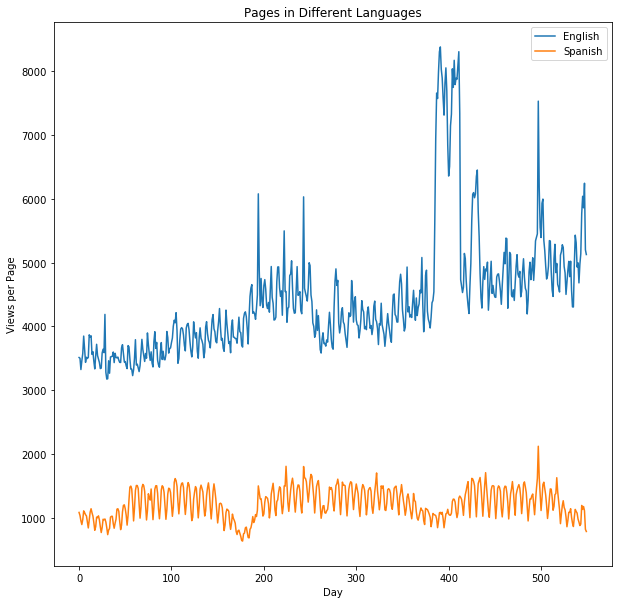

In [29]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'}

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

English shows a much higher number of views per page, as might be expected since Wikipedia is a US-based site. There is a lot more structure here than I would have expected. The English and Russian plots show very large spikes around day 400 (around August 2016), with several more spikes in the English data later in 2016. My guess is that this is the effect of both the Summer Olympics in August and the election in the US. There's also a strange feature in the English data around day 200.

The Spanish data is very interesting too. There is a clear periodic structure there, with a ~1 week fast period and what looks like a significant dip around every 6 months or so.


#### $\star$ Periodic structure and FFTs:

Since it looks like there is some periodic structure here, I will plot each of these separately so that the scale is more visible. Along with the individual plots, I will also look at the magnitude of the Fast Fourier Transform (FFT). Peaks in the FFT show us the strongest frequencies in the periodic signal.

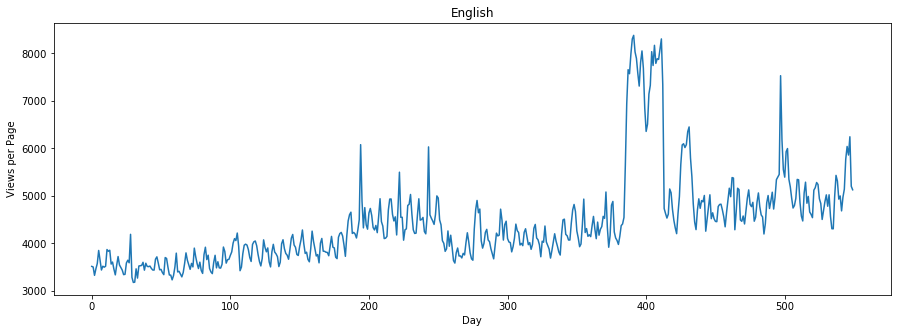

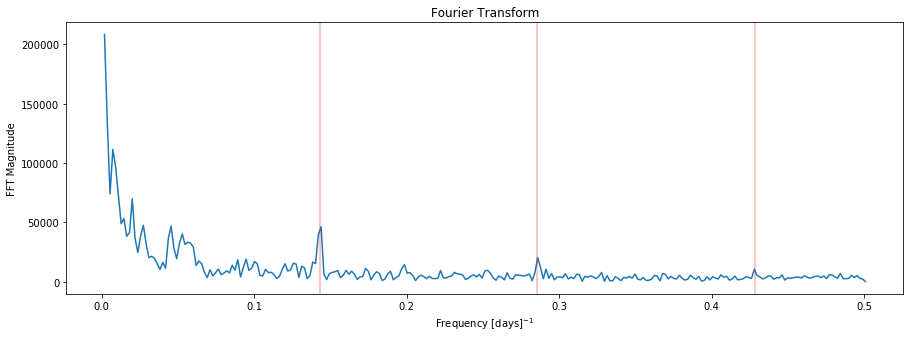

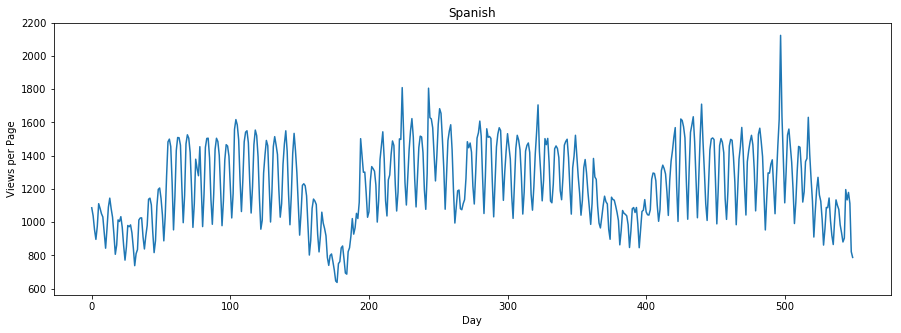

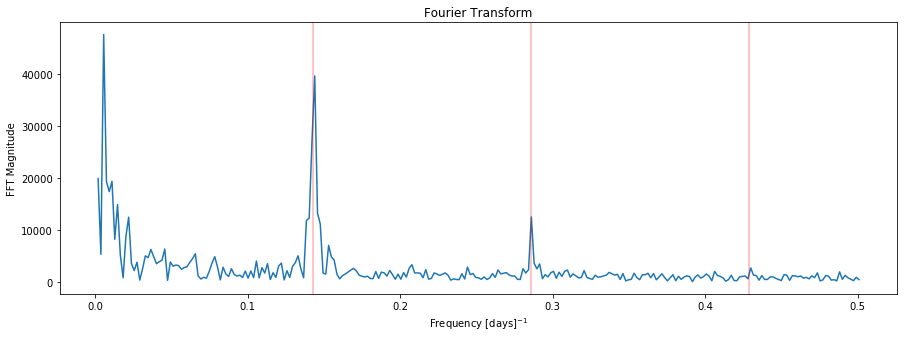

In [30]:
def plot_with_fft(key):

    fig = plt.figure(1,figsize=[15,5])
    plt.ylabel('Views per Page')
    plt.xlabel('Day')
    plt.title(labels[key])
    plt.plot(days,sums[key],label = labels[key] )
    
    fig = plt.figure(2,figsize=[15,5])
    fft_complex = fft(sums[key])
    fft_mag = [np.sqrt(np.real(x)*np.real(x)+np.imag(x)*np.imag(x)) for x in fft_complex]
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
        
    plt.ylabel('FFT Magnitude')
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title('Fourier Transform')
    plt.plot(fft_xvals[1:],fft_mag[1:],label = labels[key] )
    # Draw lines at 1, 1/2, and 1/3 week periods
    plt.axvline(x=1./7,color='red',alpha=0.3)
    plt.axvline(x=2./7,color='red',alpha=0.3)
    plt.axvline(x=3./7,color='red',alpha=0.3)
    plt.show()
    
for key in sums:
    plot_with_fft(key)

From this we see that while the Spanish data has the strongest periodic features, most of the other languages show some periodicity as well. For some reason the Russian and media data do not seem to show much. I plotted red lines where a period of 1, 1/2, and 1/3 week would appear. We see that the periodic features are mainly at 1 and 1/2 week. This is not surprising since browsing habits may differ on weekdays compared to weekends, leading to peaks in the FFTs at frequencies of n/(1 week) for integer n. So, we've learned now that page views are not at all smooth. There is some regular variation from day to day, but there are also large effects that can happen quite suddenly. A model likely will not be able to predict the sudden spikes unless it can be fed more information about what is going on in the world that day.

#### $\star$ Individual entrydata

Now, I'll plot the data for some individual entries. I've picked some entries to look at, but there's not necessarily anything special about them.


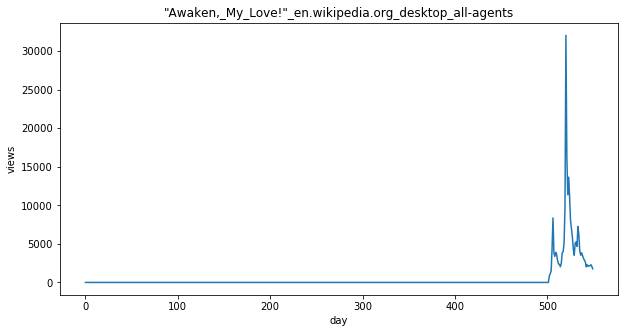

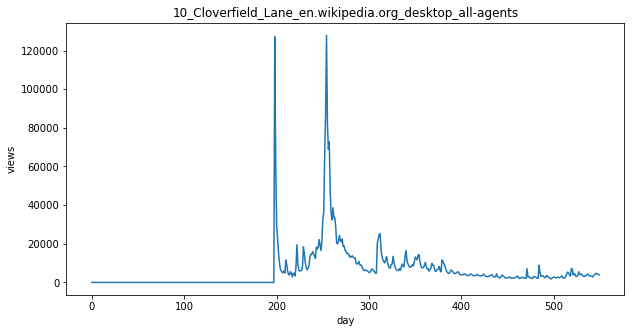

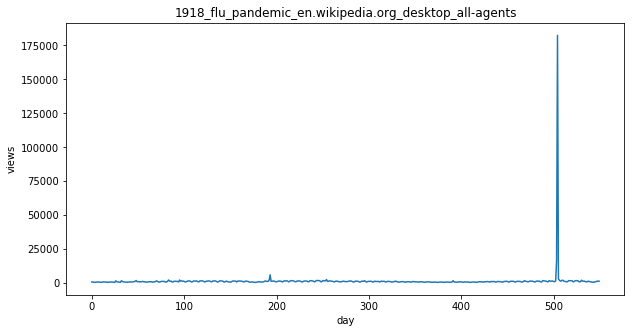

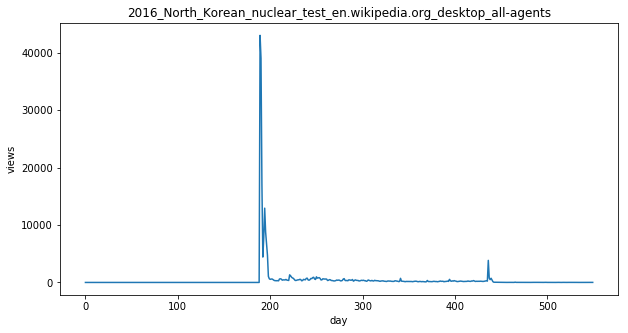

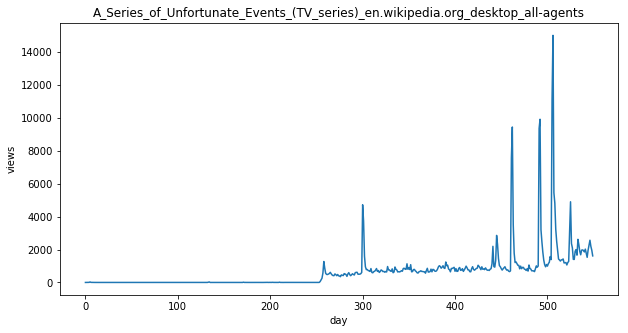

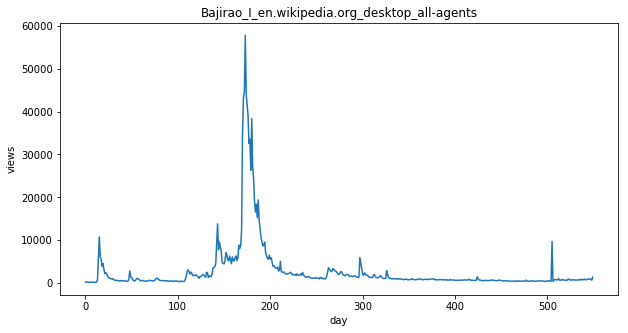

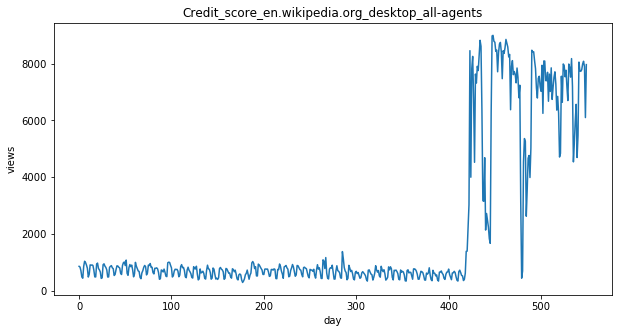

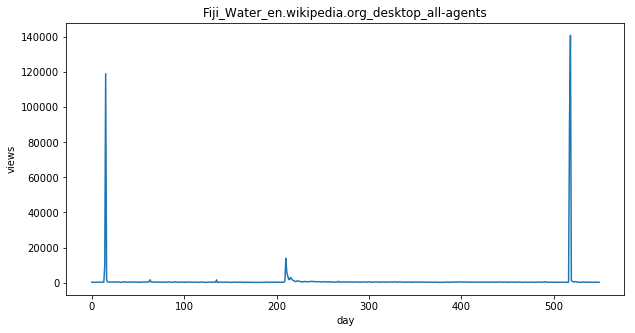

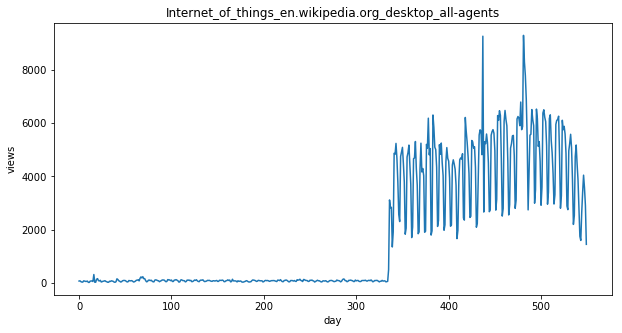

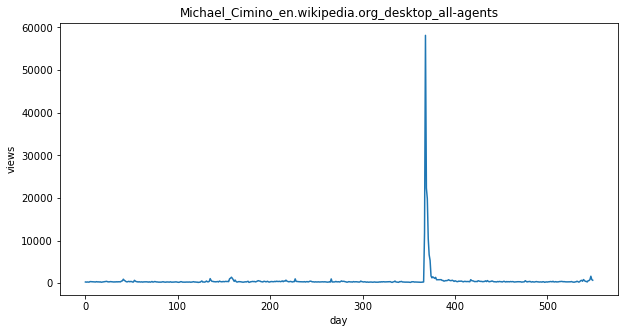

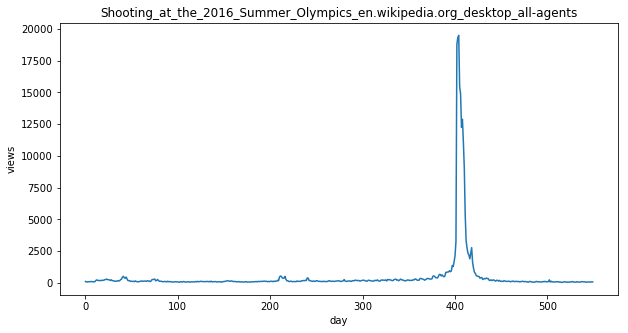

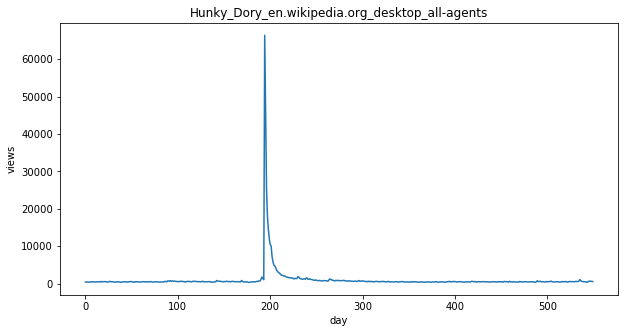

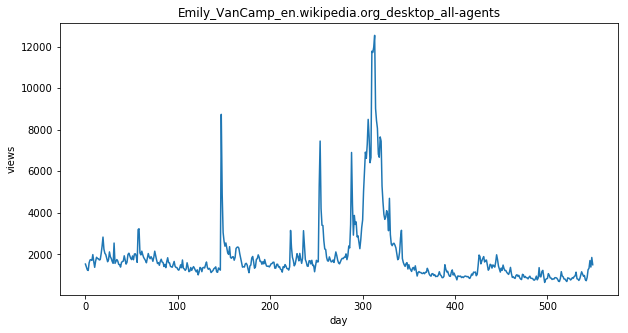

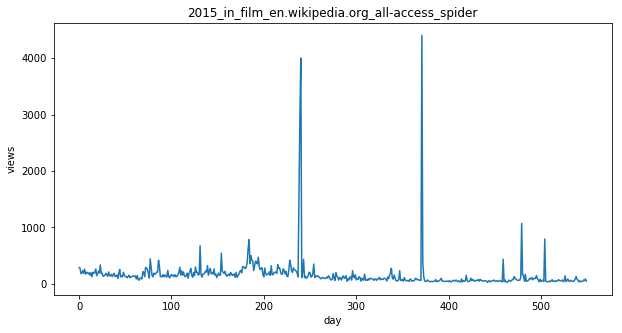

In [31]:
def plot_entry(key,idx):
    data = lang_sets[key].iloc[idx,1:]
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days,data)
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title(train_df3.iloc[lang_sets[key].index[idx],0])
    plt.show()
    
# let's look at some English pages
idx = [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]
for i in idx:
    plot_entry('en',i)

We see that for individual pages, the data is also not smooth. There are sudden gigantic spikes, large shifts in the mean number of views, and other things. We can also clearly see the effects of current events on Wikipedia views.

The 2016 North Korean nuclear test occurred, and a Wikipedia page was quickly constructed and received a huge number of views in a short time. The number of views mostly decayed away in 1 or 2 weeks.

Hunky Dory received a large number of viewers around the beginning of 2016, corresponding to the death of David Bowie.

The page about the shooting competition at the 2016 Olympics had a small number of views and then suddenly a lot right around the Olympics.

There are also some oddities, like two huge spikes in the data for Fiji Water, and the sudden long-term increases in traffic to "Internet of Things" and "Credit score." Maybe there were some news stories about Fiji water on those days. For the others, maybe there was a change in search engine behavior or maybe some new links appeared in very visible locations.


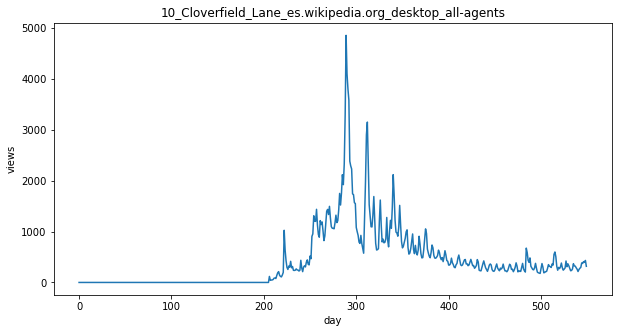

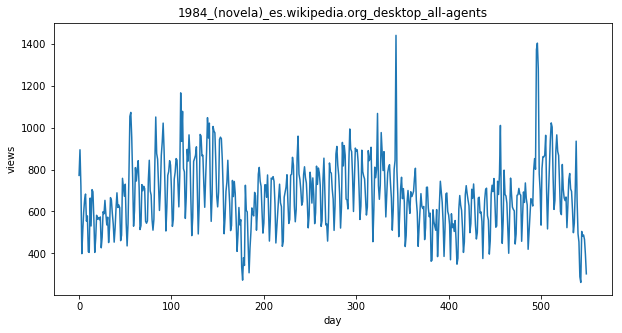

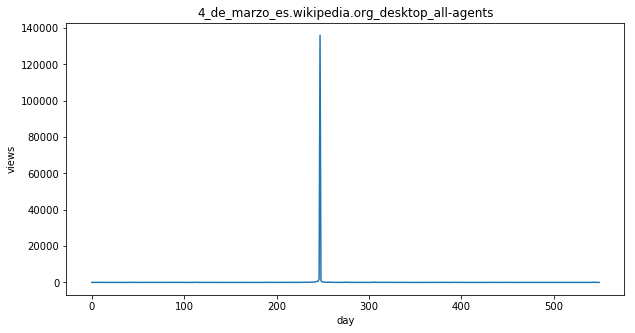

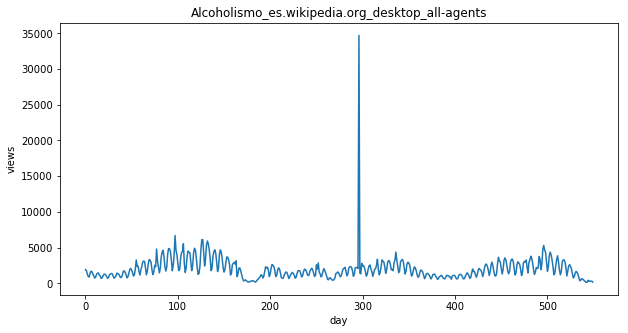

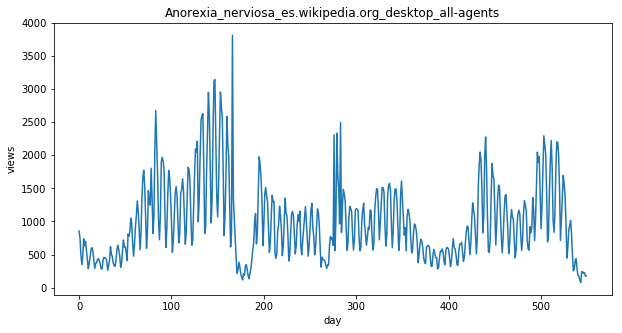

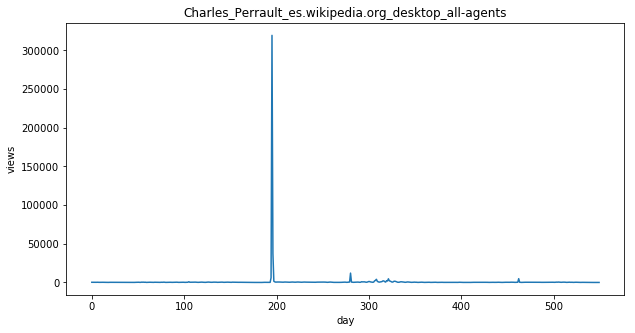

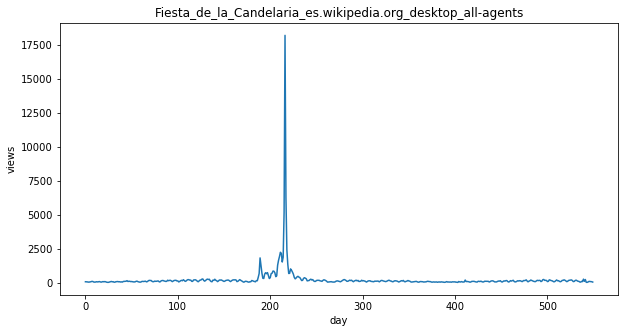

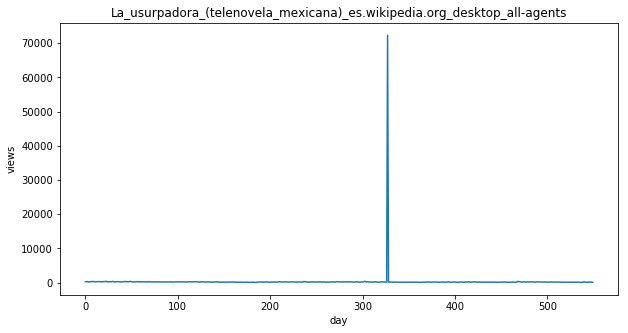

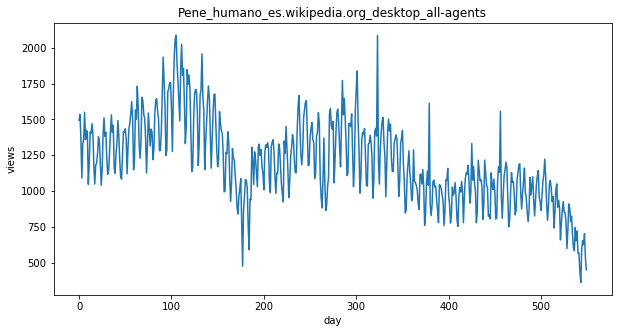

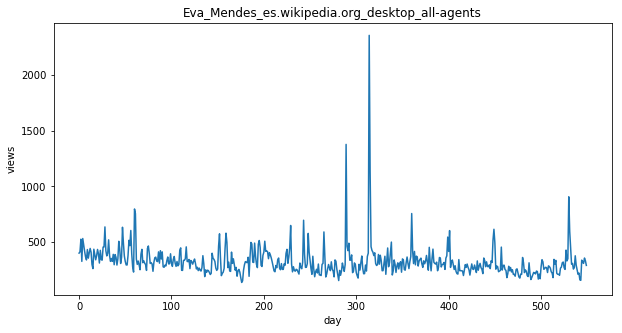

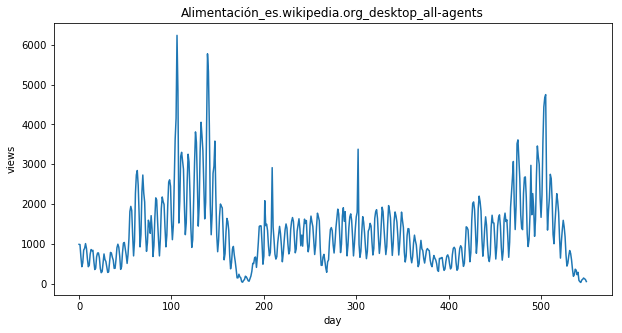

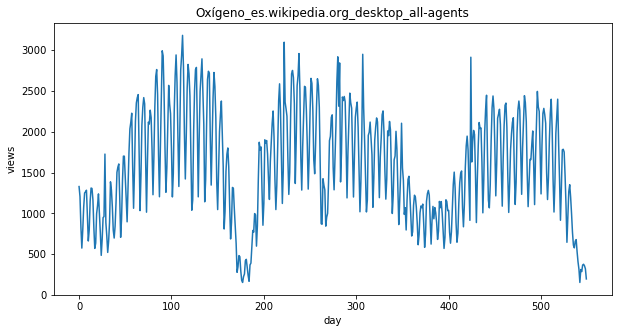

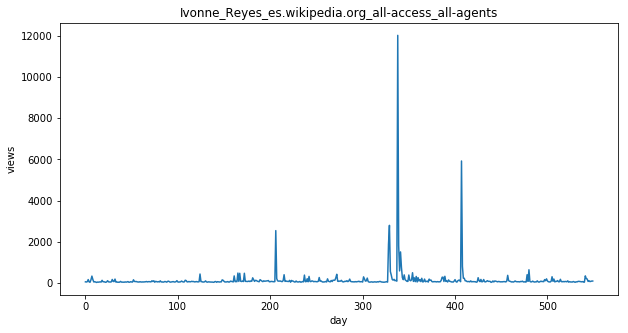

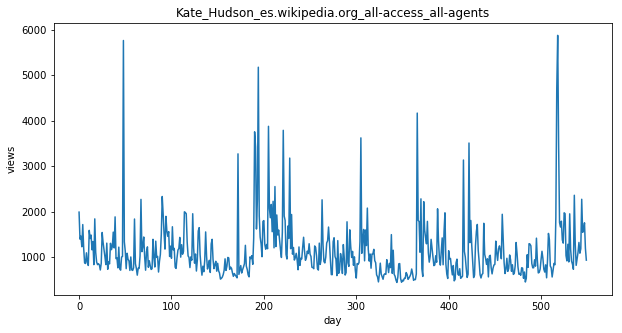

In [32]:
# let's look at some Spanish entries
idx = [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]
for i in idx:
    plot_entry('es',i)

This shows even more extreme short-term spikes than the English data. If some of these are just one or two days before reverting back to the mean, they may be a sign that something is wrong with the data. To deal with extremely short spikes, which we almost certainly won't be able to predict, something like a median filter can be used to remove them.

We see something very curious here, though. We see that a very strong periodic structure appears only in certain pages. The plots showing the strongest periodic structure actually all have something in common - they all seem to have something to do with health topics. The weekly structure might make sense if it's related to people seeing doctors and then consulting Wikipedia. The longer (~6 month) structure is harder to explain, especially without having any browser demographic information.


#### $\star$ How does the aggregated data compare to the most popular pages

I mentioned some of the potential problems with the aggregated data, so I'll now look at the most popular pages, which are generally going to be the main pages for the languages in this dataset

In [33]:
# Ffor each language get highest few pages
npages = 3
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key][['Page']])
    sum_set['total'] = lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values('total',ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print('\n\n')

en
                                                    Page        total
38573   Main_Page_en.wikipedia.org_all-access_all-agents  12066181102
9774       Main_Page_en.wikipedia.org_desktop_all-agents   8774497458
74114   Main_Page_en.wikipedia.org_mobile-web_all-agents   3153984882
39180  Special:Search_en.wikipedia.org_all-access_all...   1304079353
10403  Special:Search_en.wikipedia.org_desktop_all-ag...   1011847748
74690  Special:Search_en.wikipedia.org_mobile-web_all...    292162839
39172  Special:Book_en.wikipedia.org_all-access_all-a...    133993144
10399   Special:Book_en.wikipedia.org_desktop_all-agents    133285908
33644       Main_Page_en.wikipedia.org_all-access_spider    129020407
34257  Special:Search_en.wikipedia.org_all-access_spider    124310206



es
                                                     Page      total
92205   Wikipedia:Portada_es.wikipedia.org_all-access_...  751492304
95855   Wikipedia:Portada_es.wikipedia.org_mobile-web_...  565077372
90810   Especi

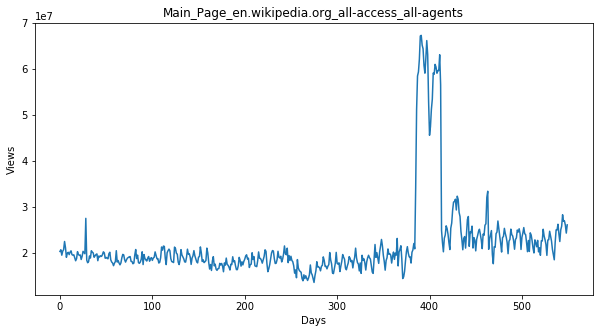

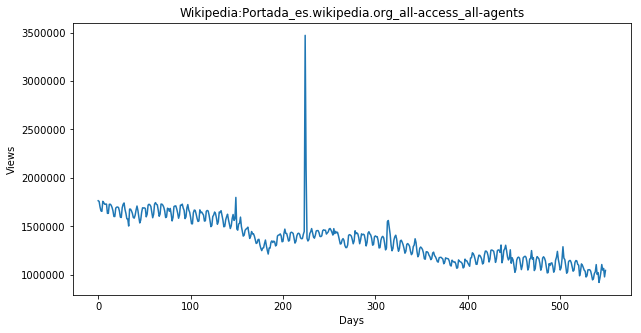

In [34]:
for key in top_pages:
    fig = plt.figure(1,figsize=(10,5))
    cols = train_df3.columns
    cols = cols[1:-1]
    data = train_df3.loc[top_pages[key],cols]
    plt.plot(days,data)
    plt.xlabel('Days')
    plt.ylabel('Views')
    plt.title(train_df3.loc[top_pages[key],'Page'])
    plt.show()
    
del train_df3

Comparing these to the aggregated data, we see that things are mostly pretty similar. I'm actually quite surprised that the Olympics would have such a huge effect on a site like Wikipedia. I would say that the Japanese, Spanish, and media data differ the most. For media pages, this is expected since most people will access pages via links from other sites rather than through the main page or search function. The fact that some of the languages show large differences between the main page and the aggregated data suggests that the dataset is perhaps not very representative of all traffic to Wikipedia.

### 4. Predicting annual spikes with "This Day in History"

In [35]:
train_df4 = train_1.copy()
train_df4 = train_df4.fillna(0)

def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res.group()[:2]
    return 'na'

for col in train_1.columns[1:]:
    train_1[col] = pd.to_numeric(train_1[col],downcast='integer')
    
train_df4['lang'] = train_df4.Page.map(get_language)

The motivation for this module is based on the assumption that if annual "spikes" in traffic can be observed to occur on the same date or at least in the same date range for two or more years, then there's a good reason to believe that a spike will occur in the following year.** Since SMAPE heavily punishes under-forecasting, it doesn't make sense to just neglect spike trends and forecast normal medians or something to that effect. Furthermore, its doubtful that any statistical or ML model, .e.g ARIMA, RNN, XGBoost, etc. could adequately predict these spike with such limited data. It's best to go with common sense and manually add them in after your baseline forecasts have been established.

Spikes going back two years cannot be validated in the range of interest for Stage 1 because data only for the first quarter of 2016 is available. However, spikes for the past two years can be validated and used for prediction in Stage 2, because data for the third and fourth quarters of 2015 and 2016 is available.

There are several outstanding events in the Stage 2 date range (09/10/2017 - 11/10-2017) that we can all agree should have predictable spikes:
- 1.September 11th Attacks (September 11th)
- 2.Halloween (October 31st)
- 3.Release of iPhone 7s (or iPhone 8) (previous models were typically released in mid to late September)

However, there are a few major events that garner attention that one may not be aware of. For example, how about the final release of John F. Kennedy's assassination documents on October 26th 2017, which on a side note also happens to fall within the anniversary range of the Cuban Missile Crisis? In any case, while some events are obvious, there are too many to keep track of, so it is inevitable that some will "slip through the cracks."

Thankfully, using Wikipedia pages for each day of the year, we can generate dictionaries that capture many events that could be of recurring interest year after year. Each page can be thought of as "This Day in History", as it contains links to key anniversaries, events, births, deaths, holidays, etc. that fall on the particular date that a page covers. Of course, not all events are significant to generate recurring traffic year after year, so this kernel is at best a starting point for further investigation into spike forecasting.

Before going further, let's establish that certain articles exist that have very clear and predictable traffic spikes:


In [36]:
def range_analysis(article, start, end):
    fig = plt.figure(1,figsize=(25,10))

    series_2015 = train_df4[train_df4['Page'] == '{0}_en.wikipedia.org_all-access_all-agents'.format(article)] \
                        .loc[:,'2015-{}'.format(start):'2015-{}'.format(end)]
    series_2016 = train_df4[train_df4['Page'] == '{0}_en.wikipedia.org_all-access_all-agents'.format(article)] \
                        .loc[:,'2016-{}'.format(start):'2016-{}'.format(end)]
    try: # Some topics don't have series for the 'all-access_all-agents' suffix
        series_2015.transpose().plot(kind='bar', title='2015 Pattern')
        series_2016.transpose().plot(kind='bar', title='2016 Pattern')                                                                                       
    except TypeError: # If not, then 'mobile-web_all-agents' can be attempted,
        # but note that this could throw an error as well, although very rarely
        series_2015 = train_df4[train_df4['Page'] == '{0}_en.wikipedia.org_mobile-web_all-agents'.format(article)] \
                            .loc[:,'2015-{}'.format(start):'2015-{}'.format(end)]
        series_2016 = train_df4[train_df4['Page'] == '{0}_en.wikipedia.org_mobile-web_all-agents'.format(article)] \
                            .loc[:,'2016-{}'.format(start):'2016-{}'.format(end)]
        series_2015.transpose().plot(kind='bar', title='2015 Pattern')
        series_2016.transpose().plot(kind='bar', title='2016 Pattern')
    plt.show()

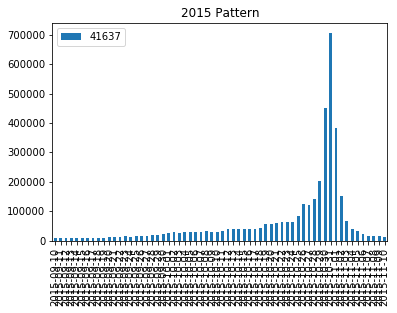

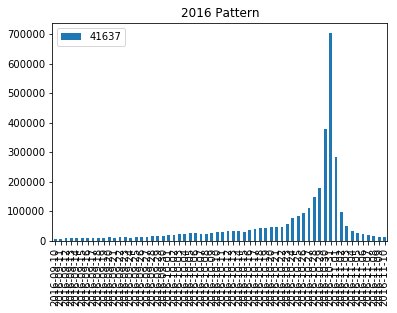

In [37]:
range_analysis('Halloween', '09-10','11-10')

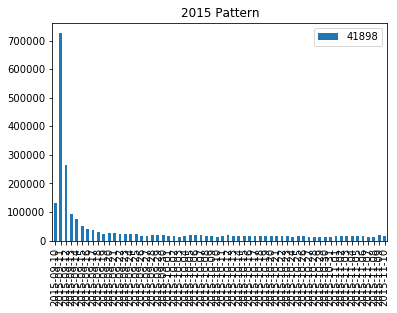

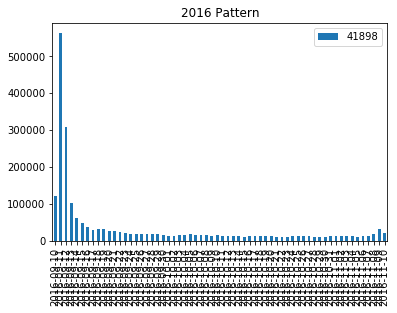

In [38]:
# time series shows similar spike pattern
range_analysis('September_11_attacks', '09-10','11-10')

As we can see from these two examples, the spikes from 2015 and 2016 are nearly a mirror image of each other. The build-up and fade have a very similar structure as well. Now are you sure you wouldn't want to at least attempt adding in a spike for 2017, versus naively predicting an informed median or going with what your model says?

Now let's investigate the structure of a typical Wikipedia date page URL so that we can automate a web scraping process that will fetch topics of interest for every day of the year:

https://en.wikipedia.org/wiki/January_1

This https:// language -wikipedia.org.wiki/ month_day structure is valid for Wikipedia articles for every date of the year, provided you can spell out every date and every month in all seven languages for which time series are available.

I've assembled dictionaries below that perform such mapping:


In [39]:
ENGLISH_MONTHS = {
          '01': 'January',
          '02': 'February',
          '03': 'March',
          '04': 'April',
          '05': 'May',
          '06': 'June',
          '07': 'July',
          '08': 'August',
          '09': 'September',
          '10': 'October',
          '11': 'November',
          '12': 'December'
         }

CHINESE_MONTHS = {
          '01': '1月',
          '02': '2月',
          '03': '3月',
          '04': '4月',
          '05': '5月',
          '06': '6月',
          '07': '7月',
          '08': '8月',
          '09': '9月',
          '10': '10月',
          '11': '11月',
          '12': '12月'
         }

Now let's use the month dictionaries along with some helper functions to create date ranges for 366 days and 7 languages. Note that the pandas date range involve using the year 2016, however this can be ignored as we only need the month and day to request and scrape articles. Discrete functions for each language are necessary because each language has its own quirks when it comes to dates. French adds "-er" to the first day of every month for example, resulting in 1er_janvier.

In [40]:
# English
def fetch_dates_en(start, end):
    en_dates = []
    date_range = pd.date_range(start,end)
    for date in date_range:
        month_day = datetime.strftime(date, '%Y-%m-%d')[-5:].split('-')
        en_dates.append(ENGLISH_MONTHS[month_day[0]] + '_{}'.format(str(int(month_day[1]))))
    return en_dates

# Chinese
def fetch_dates_zh(start, end):
    zh_dates = []
    date_range = pd.date_range(start,end)
    for date in date_range:
        month_day = datetime.strftime(date, '%Y-%m-%d')[-5:].split('-')
        zh_dates.append(CHINESE_MONTHS[month_day[0]] + '{}日'.format(str(int(month_day[1]))))
    return zh_dates

In [41]:
start_date, end_date = '2016-01-01', '2016-12-31'

# there are 366 dates for each year because 2016 was a leap year (includes Feb. 29th)
english_dates = fetch_dates_en(start_date, end_date)
assert len(english_dates) == 366
chinese_dates = fetch_dates_zh(start_date, end_date)
assert len(chinese_dates) == 366

Before scraping the Wikipedia date pages looking for articles of interest, we need to extract the article information from the dataset in each language group, so we can search for their corresponding hypyerlinks in the source HTML.


In [42]:
def get_article(page):
    res = re.search('.*_*.wiki', page)
    return res.group()[:-8] # Extract article info. only

english_articles = train_df4[train_df4['lang'] == 'en']['Page'].map(get_article).tolist()
chinese_articles = train_df4[train_df4['lang'] == 'zh']['Page'].map(get_article).tolist()
non_language_articles = train_df4[train_df4['lang'] == 'na']['Page'].map(get_article).tolist()

print('Sample English articles: {0}, {1}, {2}'.format(*english_articles[:3]), sep=',')
print('Sample Chinese articles: {0}, {1}, {2}'.format(*chinese_articles[:3]), sep=',')

Sample English articles: !vote, "Awaken,_My_Love!", "European_Society_for_Clinical_Investigation"
Sample Chinese articles: 2NE1, 2PM, 3C


Finally, let's make a function that will allow us to scrape all 366 date pages in all 7 languages, searching for articles that are both present in the dataset and on the date pages in the form of hyperlinks.

In [43]:
# the function below is responsible for the actual requesting and requires an Internet connection to call

def _request_parse_html(language, date):
    html = requests.get('https://{0}.wikipedia.org/wiki/{1}'.format(language,date))
    soup = BeautifulSoup(html.text, "html5lib")
    lists = soup.find_all('ul')
    all_articles = []
    for ul in lists:
        links = ul.find_all('a')
        for link in links:
            if language == 'ru':
                try:
                 # Russian hyperlinks have some strange encoding that I haven't figured out.
                 # We can't extract the link directly, so we'll take the title instead.
                 # In rare cases, the article titles and links differ, so matches will fail.
                 # Not as reliable as the regex below, but best we can do.
                    article = '_'.join(link['title'].split())
                    all_articles.append(article)
                except (AttributeError, KeyError, IndexError) as e:
                    continue
            elif language in {'ja', 'zh'}:
                try:
                # Asian hyperlinks have an encoding issue as well.
                # Don't need to split and rejoin though because these languages don't use spaces
                    article = link['title'] 
                    all_articles.append(article)
                except (AttributeError, KeyError, IndexError) as e:
                    continue
            else: 
                try:
                # Can extract link directly for English, French, German, Spanish
                # This extracts the article link directly and is guaranteed to work for matching links
                    article = re.search(r'(?<=/wiki/).*', link['href']).group()
                    all_articles.append(article)
                except (AttributeError, KeyError, IndexError) as e:
                    continue
    return all_articles

In [44]:
def find_key_articles(language, date, article_list):
    key_articles = set()
    date_articles = _request_parse_html(language, date)
    for article in article_list:
        if article in date_articles:
            key_articles.add(article)
    return key_articles

This is as far as this kernel can run, on Kaggle at least. The last step is to uncomment and run the following 7 blocks on your machine to get the final output. Since 2,562 (366 days * 7 languages) requests will be made, this is could take a long time, so go ahead and work on fine-tuning other parts of your model while waiting. I like to run in individual blocks by language in case have a connection issue halfway through, but you can also combine all them into one block and run it overnight or something if needed.

The final output for each block will consist of a dictionary with 366 keys - one for each day of a leap year. The keys can be accessed using English dates of the form "%B_%d", e.g. "October_7". Each value is a set containing articles in the time series dataset that are present on the Wikipedia page for its respective date. When it's all said and done, there should be the following number of articles of interest for each language:

Some redudant articles can be found in each set such as Special:MyContributions, Special:RecentChanges, Wikipedia:Contact_us. Although these articles are present in the time series data, they are not relevant for our purposes so can be ignored and/or filtered out.


In [45]:
key_english_articles = dict()
for i, date in enumerate(english_dates):
    key_articles = find_key_articles('en', date, english_articles)
    key_english_articles[english_dates[i]] = key_articles

In [46]:
key_chinese_articles = dict()
for i, date in enumerate(chinese_dates):
    key_articles = find_key_articles('zh', date, chinese_articles)
    key_chinese_articles[english_dates[i]] = key_articles
    
del train_df4

## Web Traffic Time Series Forecasting Methods

In [47]:
train = train_1.copy()
keys = key_1.copy()

def breakdown_topic(str):
    m = re.search('(.*)\_(.*).wikipedia.org\_(.*)\_(.*)', str)
    if m is not None:
        return m.group(1), m.group(2), m.group(3), m.group(4)
    else:
        return "", "", "", ""

print(breakdown_topic("Рудова,_Наталья_Александровна_ru.wikipedia.org_all-access_spider"))
print(breakdown_topic("台灣災難列表_zh.wikipedia.org_all-access_spider"))
print(breakdown_topic("File:Memphis_Blues_Tour_2010.jpg_commons.wikimedia.org_mobile-web_all-agents"))

('Рудова,_Наталья_Александровна', 'ru', 'all-access', 'spider')
('台灣災難列表', 'zh', 'all-access', 'spider')
('', '', '', '')


In [48]:
page_details = train.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
page_details[0:5]

,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider


In [49]:
unique_topic = page_details["topic"].unique()
print(unique_topic)
print("Number of distinct topics: ", unique_topic.shape[0])

['2NE1' '2PM' '3C' ..., 'Eine_Reihe_betrüblicher_Ereignisse_(Fernsehserie)'
 'ジャック・リーチャー' 'マイク眞木']
Number of distinct topics:  42213


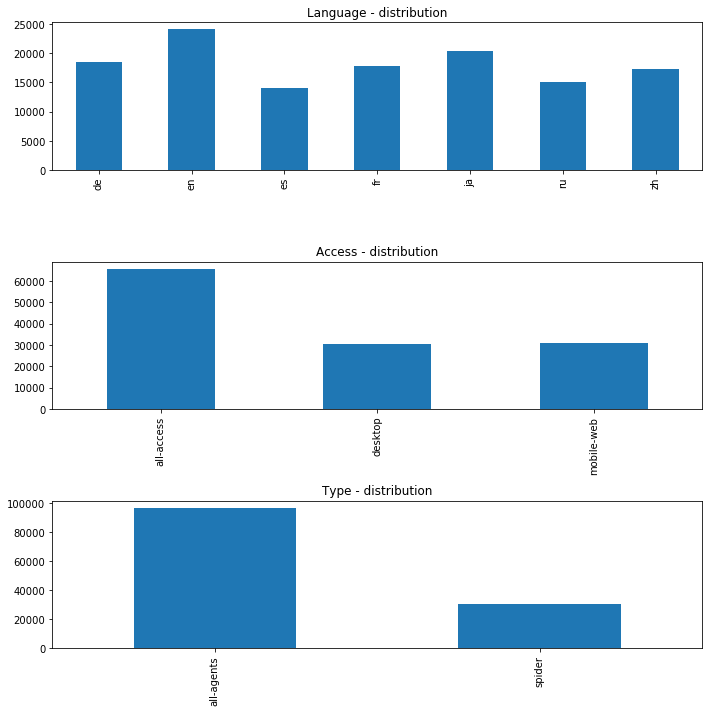

In [50]:
fig, axs  = plt.subplots(3,1,figsize=(10,10))

page_details["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

page_details["access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

page_details["type"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Type - distribution')

plt.tight_layout()

In [51]:
# generate train and validate dataset
train_df = pd.concat([page_details, train], axis=1)

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train_df, 0.1)

print("The training set sample:")
print(X_train[0:5])
print("The validation set sample:")
print(y_train[0:5])

The training set sample:
              topic lang      access    type  \
0              2NE1   zh  all-access  spider   
1               2PM   zh  all-access  spider   
2                3C   zh  all-access  spider   
3           4minute   zh  all-access  spider   
4  52_Hz_I_Love_You   zh  all-access  spider   

                                                Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05     ...      2016-10-23  2016-10-24  \
0         5.0        13.0        14.0     ...            26.0        25.0   
1        15.0        18.0        11.0     ...      

Next, we will show some popular methods in predicting time series. (Will work on XGBoost if I finish my study).

In [52]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

### 1. SMAPE - the measurement

SMAPE is harsh when the series is near zero. A [notebook][notebook] give a very good visualization of the SMAPE function.

After you find that there is no way to further improve quality of the result, you may consider doing a little bit hacking on SMAPE to give you better score.

[notebook]:https://www.kaggle.com/cpmpml/smape-weirdness

In [53]:
def smape(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual) * 1.0 / (abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    #print(np.sum(evals), len(data), np.sum(evals) * 1.0 / len(data))
    
    result = np.sum(evals) / len(data)
    
    return result

In [54]:
# create testing series
testing_series_1 = X_train.iloc[0, 5:494]
testing_series_2 = X_train.iloc[0, 5:494].shift(-1)
testing_series_3 = X_train.iloc[1, 5:494]
testing_series_4 = pd.Series([0,0,0,0])

# create random series
random_series_1 = pd.Series(np.repeat(3, 500))
random_series_2 = pd.Series(np.random.normal(3, 1, 500))
random_series_3 = pd.Series(np.random.normal(500, 20, 500))
random_series_4 = pd.Series(np.repeat(500, 500))

# testing 1 same series
print("\nSMAPE score to predict a constant array of 3")
print("Score (same series): %.3f" % smape(random_series_1, random_series_1))
print("Score (same series - 1) %.3f" % smape(random_series_1, random_series_1-1))
print("Score (same series + 1) %.3f" % smape(random_series_1, random_series_1+1))

# testing 2 same series shift by one
print("\nSMAPE score to predict a array of normal distribution around 3")
print("Score (random vs mean) %.3f" % smape(random_series_2, random_series_1))
print("Score (random vs mean-1) %.3f" % smape(random_series_2, random_series_2-1))
print("Score (random vs mean+1) %.3f" % smape(random_series_2, random_series_2+1))
print("Score (random vs mean*0.9) %.3f" % smape(random_series_2, random_series_2*0.9))
print("Score (random vs mean*1.1) %.3f" % smape(random_series_2, random_series_2*1.1))

# testing 3 totally different series
print("\nSMAPE score to predict a array of normal distribution around 500")
print("Score (random vs mean) %.3f" % smape(random_series_3, random_series_4))
print("Score (random vs mean-20) %.3f" % smape(random_series_3, random_series_3-20))
print("Score (random vs mean+20) %.3f" % smape(random_series_3, random_series_3+20))
print("Score (random vs mean*0.9) %.3f" % smape(random_series_3, random_series_3*0.9))
print("Score (random vs mean*1.1) %.3f" % smape(random_series_3, random_series_3*1.1))


SMAPE score to predict a constant array of 3
Score (same series): 0.000
Score (same series - 1) 0.400
Score (same series + 1) 0.286

SMAPE score to predict a array of normal distribution around 3
Score (random vs mean) 0.285
Score (random vs mean-1) 0.498
Score (random vs mean+1) 0.315
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095

SMAPE score to predict a array of normal distribution around 500
Score (random vs mean) 0.031
Score (random vs mean-20) 0.041
Score (random vs mean+20) 0.039
Score (random vs mean*0.9) 0.105
Score (random vs mean*1.1) 0.095


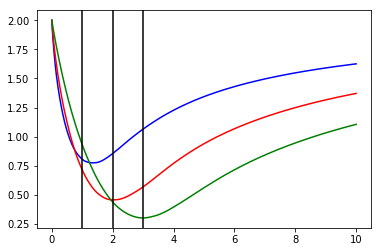

In [55]:
y_true_1 = pd.Series(np.random.normal(1, 1, 500))
y_true_2 = pd.Series(np.random.normal(2, 1, 500))
y_true_3 = pd.Series(np.random.normal(3, 1, 500))

y_pred = pd.Series(np.ones(500))
x = np.linspace(0,10,1000)

res_1 = list([smape(y_true_1, i * y_pred) for i in x])
res_2 = list([smape(y_true_2, i * y_pred) for i in x])
res_3 = list([smape(y_true_3, i * y_pred) for i in x])

plt.plot(x, res_1, color='b')
plt.plot(x, res_2, color='r')
plt.plot(x, res_3, color='g')
plt.axvline(x=1, color='k')
plt.axvline(x=2, color='k')
plt.axvline(x=3, color='k')

### 2. Simple Median Model

In [56]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

In [57]:
def median_model(df_train, df_actual, p, review=False, figSize=(12, 4)):
    
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))
    
    df_train['y'] = df_train['y'].convert_objects(convert_numeric=True)
    df_actual['y'] = df_actual['y'].convert_objects(convert_numeric=True)
    visits = nanmedian_zero(df_train['y'].values[-p:])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds
    
    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pre_forecast.append(forecast_series)
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, 
                                     title='Median model')
    
    return smape(forecast_series, actual_series)

In [58]:
# this is to demo the median model
train.iloc[[3]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0


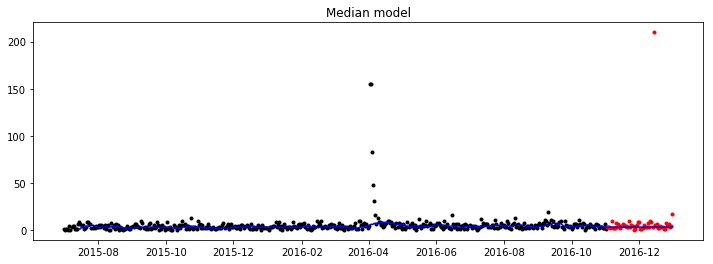

The SMAPE score is : 0.50096


In [59]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

lang = X_train.iloc[2, 1]

score = median_model(df_train.copy(), df_actual.copy(), 15, review=True)
print("The SMAPE score is : %.5f" % score)

### 3. Median Model - weekday, weekend and holiday

In [60]:
# holiday variable
# holiday_en = ['2015-01-01', '2015-01-19', '2015-04-03', '2015-05-04', '2015-05-25', '2015-07-01', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2015-12-26', '2015-12-28', '2016-01-01', '2016-01-18', '2016-03-25', '2016-05-02', '2016-05-30', '2016-07-01', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-16', '2017-04-14', '2017-05-01', '2017-05-29', '2017-07-01', '2017-07-03', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25', '2017-12-26']

holiday_en_us = ['2015-01-01', '2015-01-19', '2015-05-25', '2015-07-03', '2015-09-07', '2015-11-26', '2015-11-27', '2015-12-25', '2016-01-01', '2016-01-18', '2016-05-30', '2016-07-04', '2016-09-05', '2016-11-11', '2016-11-24', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-16', '2017-05-29', '2017-07-04', '2017-09-04', '2017-11-10', '2017-11-23', '2017-12-25']
holiday_en_uk = ['2015-01-01', '2015-04-03', '2015-05-04', '2015-05-25', '2015-12-25', '2015-12-26', '2015-12-28', '2016-01-01', '2016-03-25', '2016-05-02', '2016-05-30', '2016-12-26', '2016-12-27', '2017-01-01', '2017-04-14', '2017-05-01', '2017-05-29', '2017-12-25', '2017-12-26']
holiday_en_canada = ['2015-01-01', '2015-07-01', '2015-09-07', '2015-12-25', '2016-01-01', '2016-07-01', '2016-09-05', '2016-12-25', '2017-01-01', '2017-07-01', '2017-07-03', '2017-09-04', '2017-12-25']

holiday_ru_russia = ['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-02-23', '2015-03-09', '2015-05-01', '2015-05-04', '2015-05-09', '2015-05-11', '2015-06-12', '2015-11-04', '2016-01-01', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-02-22', '2016-02-23', '2016-03-08', '2016-05-01', '2016-05-09', '2016-06-12', '2016-06-13', '2016-11-04', '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07', '2017-02-23', '2017-02-24', '2017-03-08', '2017-05-01', '2017-05-08', '2017-05-09', '2017-06-12', '2017-11-04', '2017-11-06']
#holiday_es = ['2015-01-01', '2015-01-06', '2015-01-12', '2015-02-02', '2015-03-16', '2015-03-23', '2015-04-02', '2015-04-03', '2015-05-01', '2015-05-18', '2015-06-08', '2015-06-15', '2015-06-29', '2015-07-20', '2015-08-07', '2015-08-17', '2015-09-16', '2015-10-12', '2015-11-01', '2015-11-02', '2015-11-16', '2015-12-06', '2015-12-08', '2015-12-12', '2015-12-25', '2016-01-01', '2016-01-06', '2016-01-11', '2016-02-01', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-05-09', '2016-05-30', '2016-06-06', '2016-07-04', '2016-07-20', '2016-08-07', '2016-08-15', '2016-09-16', '2016-10-12', '2016-10-17', '2016-11-01', '2016-11-02', '2016-11-07', '2016-11-14', '2016-11-21', '2016-12-06', '2016-12-08', '2016-12-12', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-01-06', '2017-01-09', '2017-02-06', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-05-29', '2017-06-19', '2017-06-26', '2017-07-03', '2017-07-20', '2017-08-07', '2017-08-15', '2017-09-16', '2017-10-12', '2017-10-16', '2017-11-01', '2017-11-02', '2017-11-06', '2017-11-13', '2017-11-20', '2017-12-06', '2017-12-08', '2017-12-12', '2017-12-25']

holiday_es_mexico = ['2015-01-01', '2015-02-02', '2015-03-16', '2015-04-02', '2015-04-03', '2015-05-01', '2015-09-16', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-12', '2015-12-25', '2016-01-01', '2016-02-01', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-09-16', '2016-10-12', '2016-11-02', '2016-11-21', '2016-12-12', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-02', '2017-02-06', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-09-16', '2017-10-12', '2017-11-02', '2017-11-20', '2017-12-12', '2017-12-25']
holiday_es_spain = ['2017-01-01', '2017-01-06', '2017-04-14', '2017-05-01', '2017-08-15', '2017-10-12', '2017-11-01', '2017-12-06', '2017-12-08', '2017-12-25', '2016-01-01', '2016-01-06', '2016-03-25', '2016-05-01', '2016-08-15', '2016-10-12', '2016-11-01', '2016-12-06', '2016-12-08', '2016-12-25', '2015-01-01', '2015-01-06', '2015-04-03', '2015-05-01', '2015-10-12', '2015-11-01', '2015-12-06', '2015-12-08', '2015-12-25']
holiday_es_colombia = ['2015-01-01', '2015-01-12', '2015-03-23', '2015-04-02', '2015-04-03', '2015-05-01', '2015-05-18', '2015-06-08', '2015-06-15', '2015-06-29', '2015-07-20', '2015-08-07', '2015-08-17', '2015-10-12', '2015-11-02', '2015-11-16', '2015-12-08', '2015-12-25', '2016-01-01', '2016-01-11', '2016-03-21', '2016-03-24', '2016-03-25', '2016-05-01', '2016-05-09', '2016-05-30', '2016-06-06', '2016-07-04', '2016-07-20', '2016-08-07', '2016-08-15', '2016-10-17', '2016-11-07', '2016-11-14', '2016-12-08', '2016-12-25', '2017-01-01', '2017-01-09', '2017-03-20', '2017-04-13', '2017-04-14', '2017-05-01', '2017-05-29', '2017-06-19', '2017-06-26', '2017-07-03', '2017-07-20', '2017-08-07', '2017-08-15', '2017-10-16', '2017-11-06', '2017-11-13', '2017-12-08', '2017-12-25']

holiday_fr_france = ['2015-01-01', '2015-04-06', '2015-05-01', '2015-05-08', '2015-05-14', '2015-05-25', '2015-07-14', '2015-08-15', '2015-11-01', '2015-11-11', '2015-12-25', '2016-01-01', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-08', '2016-05-16', '2016-07-14', '2016-08-15', '2016-11-01', '2016-11-11', '2016-12-25', '2017-01-01', '2017-04-17', '2017-05-01', '2017-05-08', '2017-05-25', '2017-06-05', '2017-07-14', '2017-08-15', '2017-11-01', '2017-11-11', '2017-12-25']
holiday_jp_japan = ['2015-01-01', '2015-01-12', '2015-02-11', '2015-03-21', '2015-04-29', '2015-05-03', '2015-05-04', '2015-05-05', '2015-05-06', '2015-07-20', '2015-09-21', '2015-09-22', '2015-09-23', '2015-10-12', '2015-11-03', '2015-11-23', '2015-12-23', '2016-01-01', '2016-01-11', '2016-02-11', '2016-03-21', '2016-04-29', '2016-05-03', '2016-05-04', '2016-05-05', '2016-07-18', '2016-08-11', '2016-09-19', '2016-09-22', '2016-10-10', '2016-11-03', '2016-11-23', '2016-12-23', '2017-01-01', '2017-01-09', '2017-02-11', '2017-03-20', '2017-04-29', '2017-05-03', '2017-05-04', '2017-05-05', '2017-07-17', '2017-08-11', '2017-09-18', '2017-09-22', '2017-10-09', '2017-11-03', '2017-11-23', '2017-12-23']

#holiday_de = ['2015-01-01', '2015-01-06', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-06-04', '2015-08-01', '2015-08-15', '2015-10-03', '2015-10-26', '2015-11-01', '2015-12-08', '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-05-26', '2016-08-01', '2016-08-15', '2016-10-03', '2016-10-26', '2016-11-01', '2016-12-08', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-06-15', '2017-08-01', '2017-08-15', '2017-10-03', '2017-10-26', '2017-10-31', '2017-11-01', '2017-12-08', '2017-12-25', '2017-12-26']

holiday_de_germany = ['2015-01-01', '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-14', '2015-05-25', '2015-10-03', '2015-12-25', '2015-12-26', '2016-01-01', '2016-03-25', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-10-03', '2016-12-25', '2016-12-26', '2017-01-01', '2017-04-14', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03', '2017-10-31', '2017-12-25', '2017-12-26']
holiday_de_austria = ['2015-01-01', '2015-01-06', '2015-04-06', '2015-05-01', '2015-05-14', '2015-05-25', '2015-06-04', '2015-08-15', '2015-10-26', '2015-11-01', '2015-12-08', '2015-12-25', '2015-12-26', '2016-01-01', '2016-01-06', '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16', '2016-05-26', '2016-08-15', '2016-10-26', '2016-11-01', '2016-12-08', '2016-12-25', '2016-12-26', '2017-01-01', '2017-01-06', '2017-04-17', '2017-05-01', '2017-05-25', '2017-06-05', '2017-06-15', '2017-08-15', '2017-10-26', '2017-11-01', '2017-12-08', '2017-12-25', '2017-12-26']
holiday_de_switzerland = ['2015-01-01', '2015-04-03', '2015-05-14', '2015-08-01', '2015-12-25', '2016-01-01', '2016-03-25', '2016-05-05', '2016-08-01', '2016-12-25', '2017-01-01', '2017-04-14', '2017-05-25', '2017-08-01', '2017-12-25']

#holiday_zh = ['2015-01-01', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-27', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-05-01', '2015-05-25', '2015-06-19', '2015-06-20', '2015-07-01', '2015-09-03', '2015-09-28', '2015-10-01', '2015-10-09', '2015-10-10', '2015-10-21', '2015-12-25', '2015-12-26', '2016-01-01', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-29', '2016-03-25', '2016-03-26', '2016-03-28', '2016-04-04', '2016-04-05', '2016-05-01', '2016-05-02', '2016-05-14', '2016-06-09', '2016-06-10', '2016-07-01', '2016-09-15', '2016-09-16', '2016-09-28', '2016-10-01', '2016-10-10', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-27', '2017-02-28', '2017-04-03', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01', '2017-05-03', '2017-05-29', '2017-05-30', '2017-07-01', '2017-10-01', '2017-10-02', '2017-10-04', '2017-10-05', '2017-10-09', '2017-10-10', '2017-10-28', '2017-12-25', '2017-12-26']

holiday_zh_hongkong = ['2015-01-01', '2015-02-19', '2015-02-20', '2015-04-03', '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07', '2015-05-01', '2015-05-25', '2015-06-20', '2015-07-01', '2015-09-03', '2015-09-28', '2015-10-01', '2015-10-21', '2015-12-25', '2015-12-26', '2016-01-01', '2016-02-08', '2016-02-09', '2016-02-10', '2016-03-25', '2016-03-26', '2016-03-28', '2016-04-04', '2016-05-01', '2016-05-02', '2016-05-14', '2016-06-09', '2016-07-01', '2016-09-16', '2016-10-01', '2016-10-10', '2016-12-25', '2016-12-26', '2016-12-27', '2017-01-01', '2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01', '2017-05-03', '2017-05-30', '2017-07-01', '2017-10-01', '2017-10-02', '2017-10-05', '2017-10-28', '2017-12-25', '2017-12-26']
holiday_zh_taiwan = ['2015-01-01', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-23', '2015-02-27', '2015-04-03', '2015-04-05', '2015-04-06', '2015-06-19', '2015-06-20', '2015-09-28', '2015-10-09', '2015-10-10', '2016-01-01', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10', '2016-09-15', '2016-09-16', '2016-09-28', '2016-10-10', '2017-01-01', '2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-27', '2017-02-28', '2017-04-03', '2017-04-04', '2017-05-01', '2017-05-29', '2017-05-30', '2017-10-04', '2017-10-09', '2017-10-10']

holidays_en_us = pd.DataFrame({
  'holiday': 'US public holiday',
  'ds': pd.to_datetime(holiday_en_us),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_uk = pd.DataFrame({
  'holiday': 'UK public holiday',
  'ds': pd.to_datetime(holiday_en_uk),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en_canada = pd.DataFrame({
  'holiday': 'Canada public holiday',
  'ds': pd.to_datetime(holiday_en_canada),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_en = pd.concat((holidays_en_us, holidays_en_uk, holidays_en_canada))

holidays_ru_russia = pd.DataFrame({
  'holiday': 'Russia public holiday',
  'ds': pd.to_datetime(holiday_ru_russia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_ru = holidays_ru_russia

holidays_es_mexico = pd.DataFrame({
  'holiday': 'Mexico public holiday',
  'ds': pd.to_datetime(holiday_es_mexico),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_spain = pd.DataFrame({
  'holiday': 'Spain public holiday',
  'ds': pd.to_datetime(holiday_es_spain),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es_colombia = pd.DataFrame({
  'holiday': 'Colombia public holiday',
  'ds': pd.to_datetime(holiday_es_colombia),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_es = pd.concat((holidays_es_mexico, holidays_es_spain, holidays_es_colombia))

holidays_fr_france = pd.DataFrame({
  'holiday': 'France public holiday',
  'ds': pd.to_datetime(holiday_fr_france),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_fr = holidays_fr_france

holidays_jp_japan = pd.DataFrame({
  'holiday': 'Japan public holiday',
  'ds': pd.to_datetime(holiday_jp_japan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_jp = holidays_jp_japan

holidays_de_germany = pd.DataFrame({
  'holiday': 'Germany public holiday',
  'ds': pd.to_datetime(holiday_de_germany),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_austria = pd.DataFrame({
  'holiday': 'Austria public holiday',
  'ds': pd.to_datetime(holiday_de_austria),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de_switzerland = pd.DataFrame({
  'holiday': 'Switzerland public holiday',
  'ds': pd.to_datetime(holiday_de_switzerland),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_de = pd.concat((holidays_de_germany, holidays_de_austria, holidays_de_switzerland))

holidays_zh_hongkong = pd.DataFrame({
  'holiday': 'HK public holiday',
  'ds': pd.to_datetime(holiday_zh_hongkong),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh_taiwan = pd.DataFrame({
  'holiday': 'Taiwan public holiday',
  'ds': pd.to_datetime(holiday_zh_taiwan),
  'lower_window': 0,
  'upper_window': 0,
})

holidays_zh = pd.concat((holidays_zh_hongkong, holidays_zh_taiwan))

holidays_dict = {"en": holidays_en, 
                 "ru": holidays_ru, 
                 "es": holidays_es, 
                 "fr": holidays_fr, 
                 "ja": holidays_jp,
                 "de": holidays_de,
                 "zh": holidays_zh}


In [61]:
def median_holiday_model(df_train, df_actual, p, lang, review=False, figSize=(12, 4)):
    # Split the train and actual set
    
    df_train['ds'] = pd.to_datetime(df_train['ds'])
    df_actual['ds'] = pd.to_datetime(df_actual['ds'])
    train_series = df_train['y']
    train_series.index = df_train.ds
    
    if(isinstance(lang, float) and math.isnan(lang)):
        df_train['holiday'] = df_train.ds.dt.dayofweek >=5
        df_actual['holiday'] = df_actual.ds.dt.dayofweek >=5
    else:
        df_train['holiday'] = (df_train.ds.dt.dayofweek >=5) | df_train.ds.isin(holidays_dict[lang].ds)
        df_actual['holiday'] = (df_actual.ds.dt.dayofweek >=5) | df_actual.ds.isin(holidays_dict[lang].ds)
     
    # Combine the train and actual set
    predict_holiday = median_holiday_helper(df_train, df_actual[df_actual.holiday], p, True)
    predict_non_holiday = median_holiday_helper(df_train, df_actual[~df_actual.holiday], p, False)

    forecast_series = predict_non_holiday.combine_first(predict_holiday)
    
    actual_series = df_actual.y
    actual_series.index = df_actual.ds
    
    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, 
                                     title='Median model with holiday')
    
    return smape(forecast_series, actual_series)

In [62]:
def median_holiday_helper(df_train, df_actual, p, holiday):
    def nanmedian_zero(a):
        return np.nan_to_num(np.nanmedian(a))
    
    df_train['y'] = pd.to_numeric(df_train['y'])
    df_actual['y'] = pd.to_numeric(df_actual['y'])
    
    sample = df_train[-p:]
    if(holiday):
        sample = sample[sample['holiday']]
    else:
        sample = sample[~sample['holiday']]

    visits = nanmedian_zero(sample['y'])
    
    idx = np.arange( p) + np.arange(len(df_train)- p+1)[:,None]
    b = [row[row>=0] for row in df_train.y.values[idx]]
    pre_forecast = pd.Series(np.append(([float('nan')] * (p-1)), list(map(nanmedian_zero,b))))
    pre_forecast.index = df_train.ds
    
    forecast_series = pd.Series(np.repeat(visits, len(df_actual)))
    forecast_series.index = df_actual.ds
    
    forecast_series = pre_forecast.append(forecast_series)
    
    return forecast_series

In [63]:
# this is to demo the median model - weekday, weekend and 
train.iloc[[3]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0


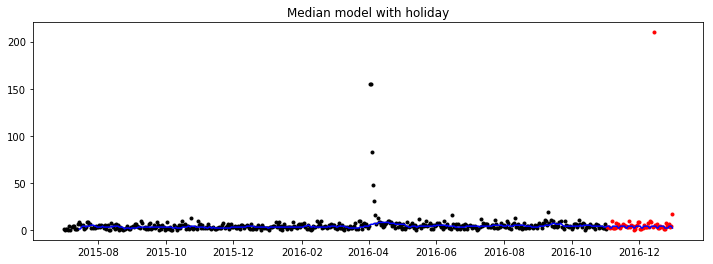

The SMAPE score is : 0.53178


In [64]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

lang = X_train.iloc[2, 1]

score = median_holiday_model(df_train.copy(), df_actual.copy(), 15, lang, review=True)
print("The SMAPE score is : %.5f" % score)

### 4. ARIMA Model

The below use the [ARIMA][ARIMA] from a Python library statsmodels. The model is slow and may throw exception if the model cannot find a solution. (Make the model difficult to build for all series).

[ARIMA]:http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html

In [65]:
from statsmodels.tsa.arima_model import ARIMA   

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = df_train.y
    train_series.index = df_train.ds

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)
                
    #print(result.params)
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    forecast_series = result.predict(start_idx, end_idx,typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, 
                                     title='ARIMA model')
    
    return smape(forecast_series, actual_series)

In [66]:
# this is to demo the ARIMA model
train.iloc[[3]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0


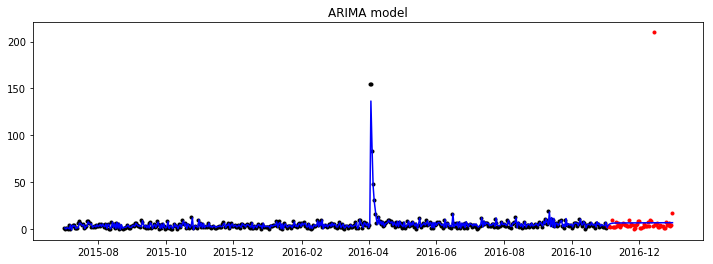

The SMAPE score is : 0.65757


In [67]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

lang = X_train.iloc[2, 1]

score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

### 5. Facebook Prophet Library

[Facebook prophet library][Facebook prophet library] is created by facebook and aims to create a human-friendly time series forecasting libary.ase refer to /

There are several favor, but I will focus on holiday, yearly and log model
[Facebook prophet library]:https://facebookincubator.github.io/prophet

In [68]:
from fbprophet import Prophet

def plot_prediction_and_actual(model, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.set_ylim(ylim)
    ax.plot(pd.to_datetime(actual.ds), actual.y, 'r.')
    model.plot(forecast, ax=ax);
    ax.set_title(title)
    plt.show()

In [69]:
# simple linear model
def normal_model(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
        
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        #
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Normal model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

In [70]:
def holiday_model(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]

    m = Prophet(holidays=holidays)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
        
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Holiday model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

In [71]:
def yearly_model(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    
    df_actual['y'] = df_actual['y'].astype('float')

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]

    m = Prophet(holidays=holidays, yearly_seasonality=True)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
        
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -100
        ymax = max(df_actual.y.max(), df_train.y.max()) +100
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Yealry model')
    
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = forecast[mask].yhat
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

In [72]:
# log model
def normal_model_log(df_train, df_actual, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)
    
    m = Prophet()
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), title='Normal model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0

    return smape(forecast_series, actual_series)

def holiday_model_log(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]
    m = Prophet(holidays=holidays)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)
    
    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), 
                                   title='Holiday model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0
    
    return smape(forecast_series, actual_series)

In [73]:
def yearly_model_log(df_train, df_actual, lang, review=False):
    start_date = df_actual.ds.min()
    end_date = df_actual.ds.max()
    
    actual_series = df_actual.y.copy()
    actual_series.index = df_actual.ds

    df_train['y'] = df_train['y'].astype('float')
    df_train.y = np.log1p(df_train.y)
    
    df_actual['y'] = df_actual['y'].astype('float')
    df_actual.y = np.log1p(df_actual.y)

    if(isinstance(lang, float) and math.isnan(lang)):
        holidays = None
    else:
        holidays = holidays_dict[lang]
        
    m = Prophet(holidays=holidays, yearly_seasonality=True)
    m.fit(df_train)
    future = m.make_future_dataframe(periods=60)
    forecast = m.predict(future)

    if(review):
        ymin = min(df_actual.y.min(), df_train.y.min()) -2
        ymax = max(df_actual.y.max(), df_train.y.max()) +2
        plot_prediction_and_actual(m, forecast, df_actual, ylim=[ymin, ymax], figSize=(12,4), 
                                   title='Yearly model in log')
        
    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    forecast_series = np.expm1(forecast[mask].yhat)
    forecast_series.index = forecast[mask].ds
    forecast_series[forecast_series < 0] = 0
    
    return smape(forecast_series, actual_series)

In [74]:
# this is to demo the facebook prophet model
train.iloc[[3]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


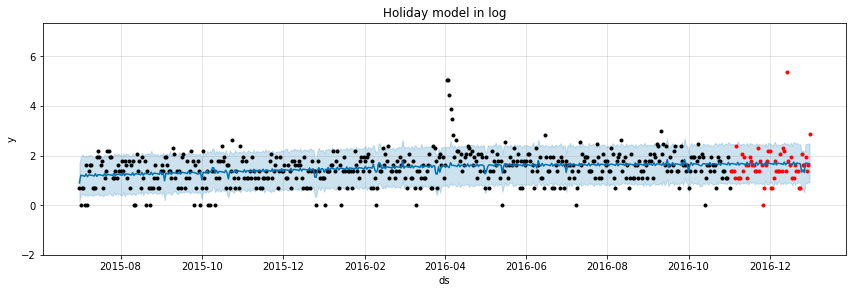

The SMAPE score is : 0.52810


In [75]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)

lang = X_train.iloc[2, 1]

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

### 6. Sample Series Analysis (For script reconciliation)

#### $\star$ Case 1: SMAPE evaluation near zero and SMAPE score is too big

In [76]:
train.iloc[[2]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


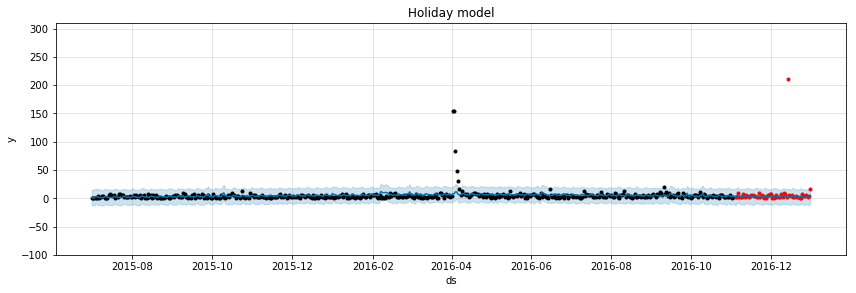

The SMAPE score is : 0.61311


In [77]:
df_train = extract_series(X_train, 2, 5)
df_actual = extract_series(y_train, 2, 5)
lang = X_train.iloc[2, 1]
score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 2: Yearly model is the best model

In [78]:
train.iloc[[4464]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
4464,Automne_fr.wikipedia.org_desktop_all-agents,188.0,177.0,142.0,107.0,107.0,167.0,170.0,205.0,170.0,...,102.0,81.0,74.0,75.0,129.0,120.0,106.0,122.0,106.0,84.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


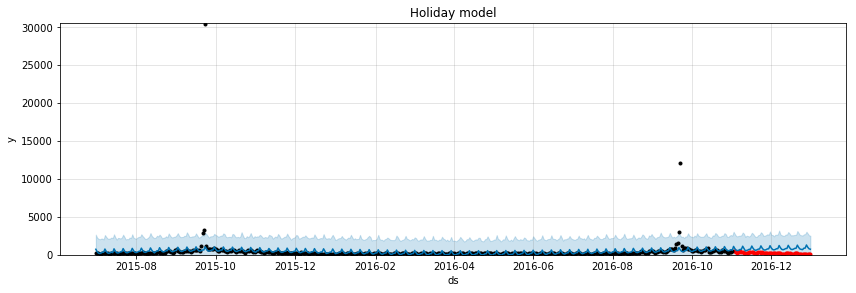

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 1.15313


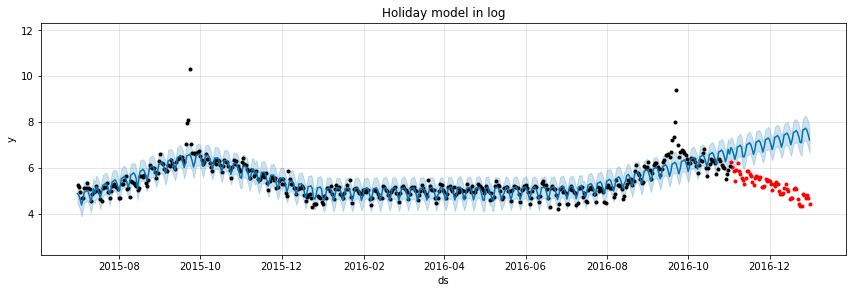

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 1.39154


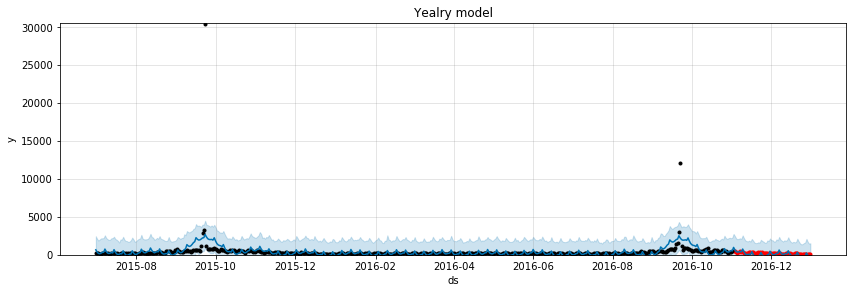

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 1.29880


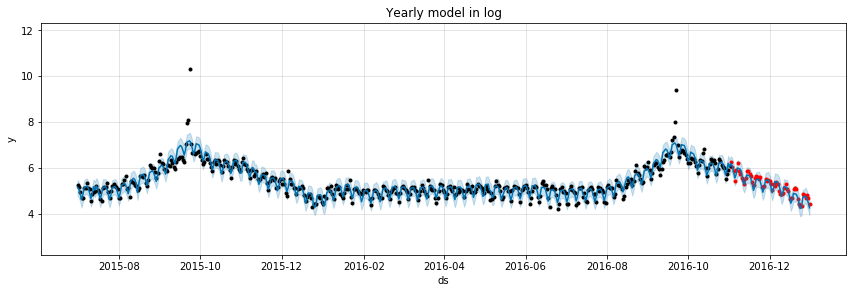

The SMAPE score is : 0.12857


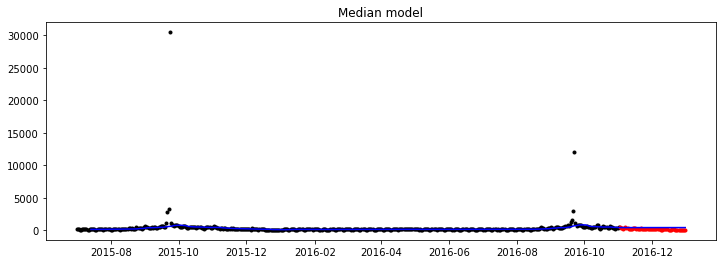

The SMAPE score is : 0.74763


In [79]:
df_train = extract_series(X_train, 4464, 5)
df_actual = extract_series(y_train, 4464, 5)
lang = X_train.iloc[4464, 1]

score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 3: Non-yearly model is better

In [80]:
train.iloc[[6245]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
6245,Antoine_Fr%C3%A9rot_fr.wikipedia.org_desktop_a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,889.0,911.0,900.0,900.0,950.0,900.0,950.0,950.0,1000.0,1000.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


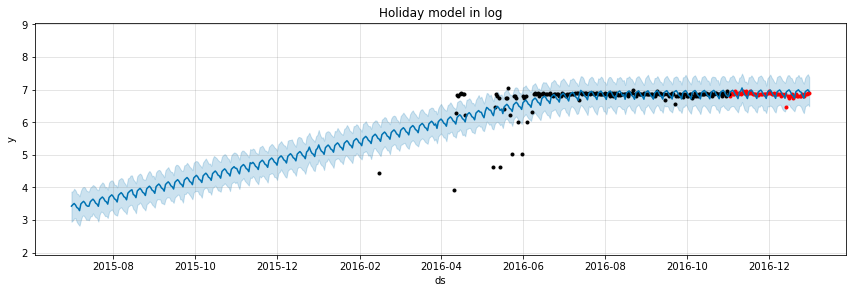

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.09137


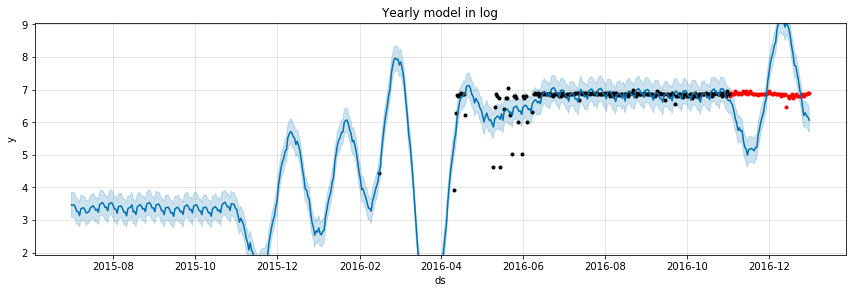

The SMAPE score is : 0.99449


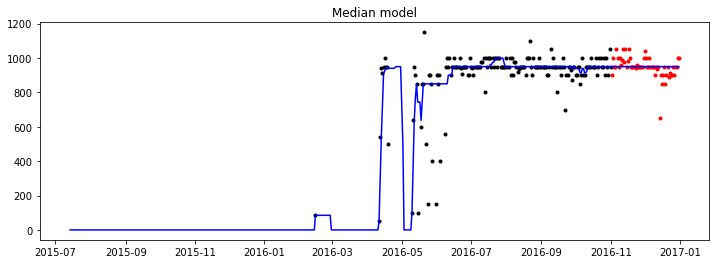

The SMAPE score is : 0.03718


In [81]:
df_train = extract_series(X_train, 6245, 5)
df_actual = extract_series(y_train, 6245, 5)
lang = X_train.iloc[6245, 1]
score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 4: SMAPE score is too high for all proposed models

In [82]:
train.iloc[[8002]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
8002,Jeux_olympiques_d'été_de_1992_fr.wikipedia.org...,49.0,29.0,48.0,47.0,36.0,78.0,62.0,50.0,65.0,...,40.0,41.0,44.0,36.0,43.0,80.0,48.0,59.0,63.0,46.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Jeux_olympiques_d'été_de_1992_fr.wikipedia.org_desktop_all-agents


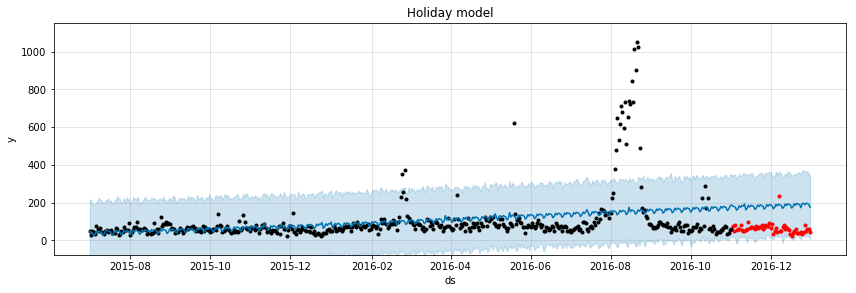

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.99798


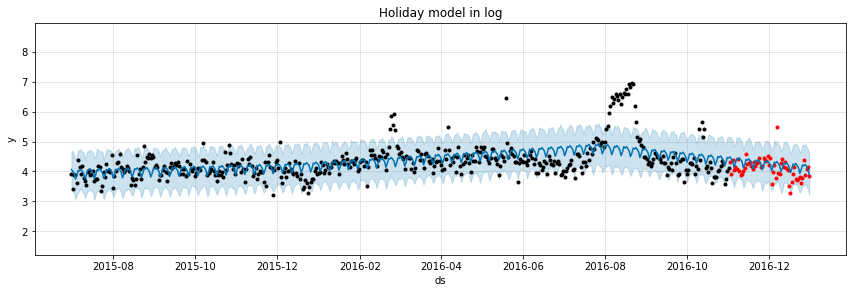

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.23956


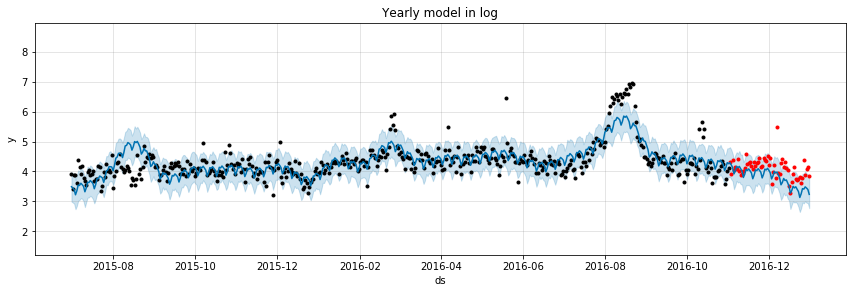

The SMAPE score is : 0.34480


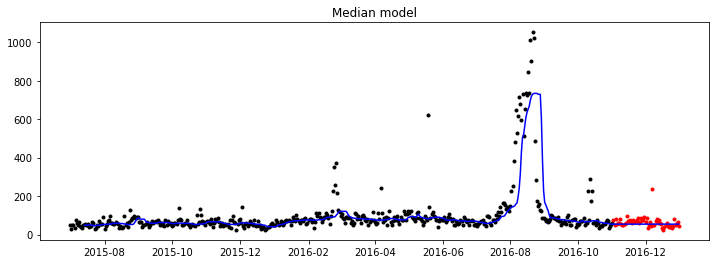

The SMAPE score is : 0.25656


In [83]:
df_train = extract_series(X_train, 8002, 5)
df_actual = extract_series(y_train, 8002, 5)
lang = X_train.iloc[8002, 1]
title = X_train.iloc[8002, 4]
print(title)

score = holiday_model(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

# Please use this case to check your implementation of SMAPE
score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 5: SMAPE score is too high for all proposed models

In [84]:
train.iloc[[10009]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
10009,Om_Puri_en.wikipedia.org_desktop_all-agents,605.0,625.0,663.0,622.0,634.0,798.0,705.0,687.0,655.0,...,473.0,440.0,472.0,526.0,662.0,671.0,987.0,898.0,1130.0,1091.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Om_Puri_en.wikipedia.org_desktop_all-agents


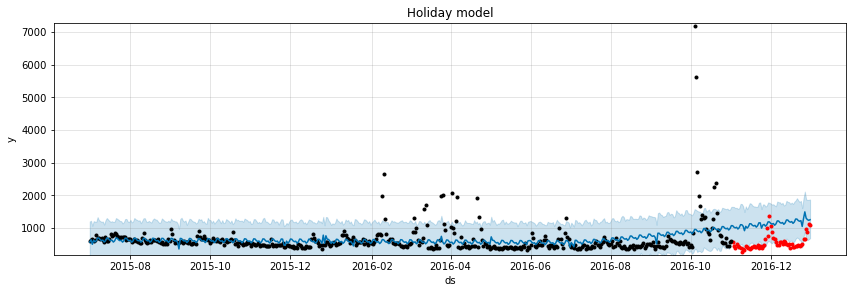

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.72466


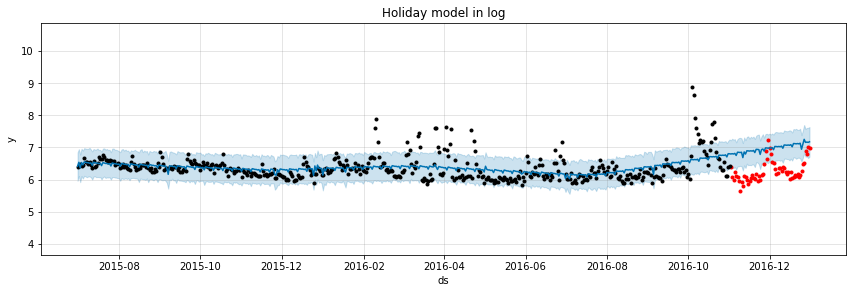

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.67401


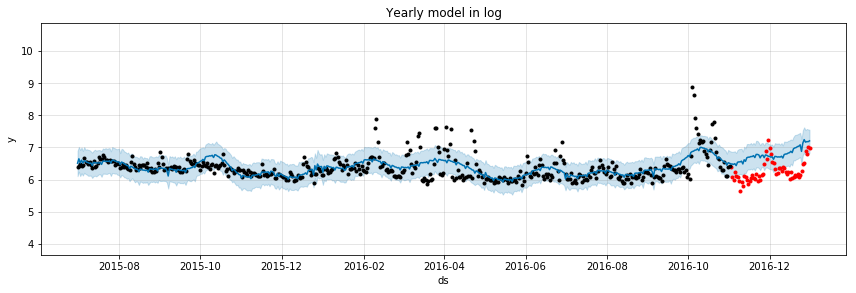

The SMAPE score is : 0.51402


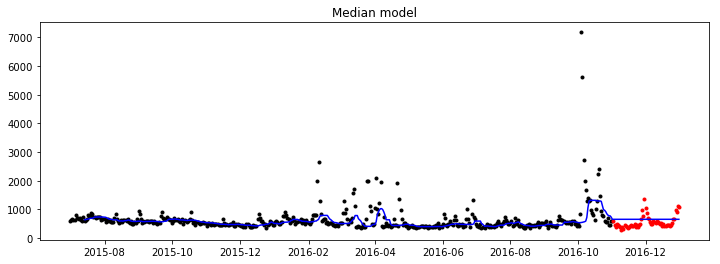

The SMAPE score is : 0.34312


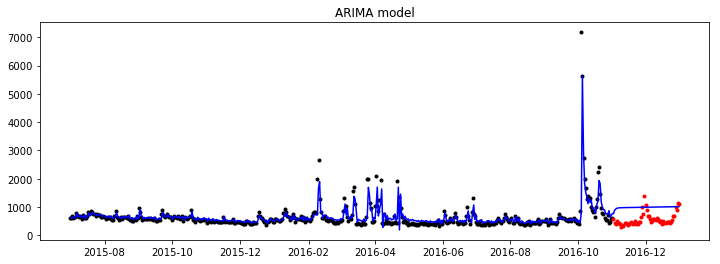

The SMAPE score is : 0.60952


In [85]:
df_train = extract_series(X_train, 10009, 5)
df_actual = extract_series(y_train, 10009, 5)
lang = X_train.iloc[10009, 1]
title = X_train.iloc[10009, 4]
print(title)

score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang=lang)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

score = arima_model(df_train.copy(), df_actual.copy(), 2, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 6: SMAPE score is too high for all proposed models

In [86]:
train.iloc[[14211]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
14211,File:Libyan_Civil_War.svg_commons.wikimedia.or...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,6.0,13.0,7.0,1.0,10.0,6.0,11.0,7.0,7.0


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


File:Libyan_Civil_War.svg_commons.wikimedia.org_all-access_spider


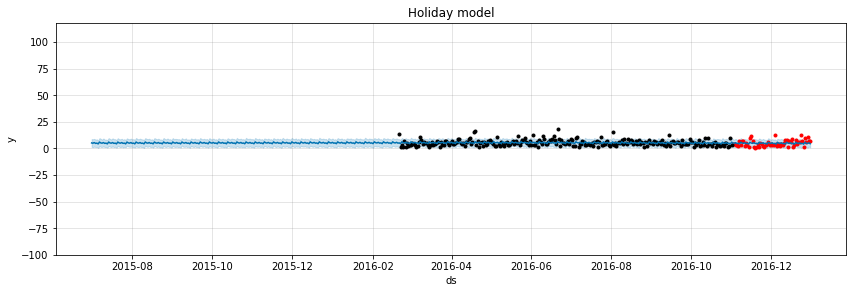

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.56180


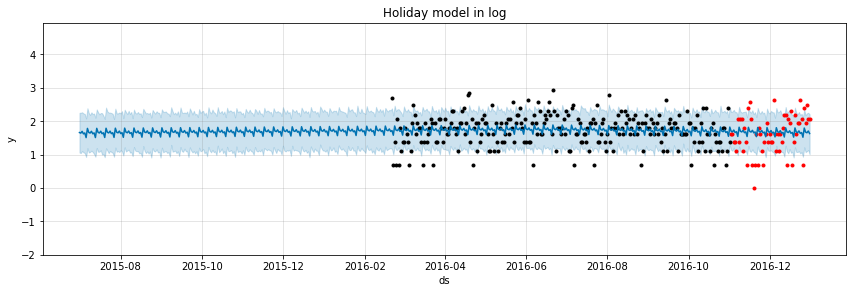

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.56230


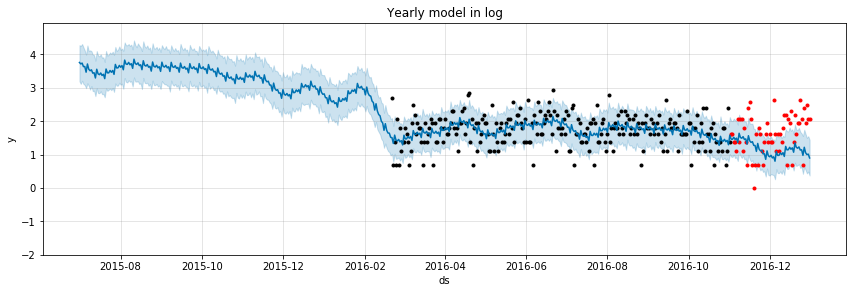

The SMAPE score is : 0.78536


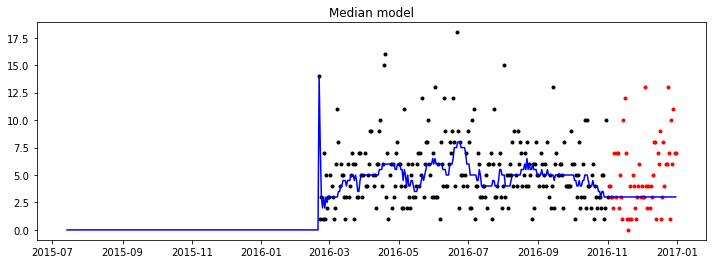

The SMAPE score is : 0.61357


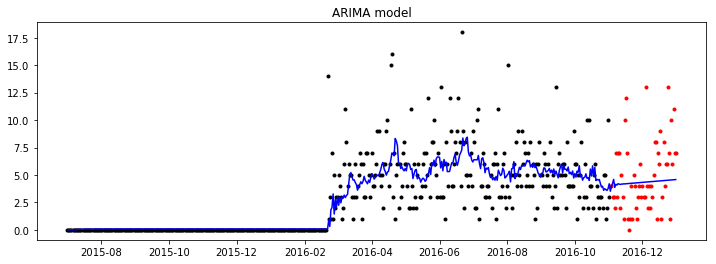

The SMAPE score is : 0.55541


In [87]:
df_train = extract_series(X_train, 14211, 5)
df_actual = extract_series(y_train, 14211, 5)
lang = X_train.iloc[14211, 1]
title = X_train.iloc[14211, 4]
print(title)
score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang = lang)
print("The SMAPE score is : %.5f" % score)

score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
print("The SMAPE score is : %.5f" % score)

# if there is too many zero, just use normal is OK.
score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
print("The SMAPE score is : %.5f" % score)

score = arima_model(df_train.copy(), df_actual.copy(), 7, 1, 2, review=True)
print("The SMAPE score is : %.5f" % score)

#### $\star$ Case 7: Adhoc study

In [88]:
series_num = 14505

train.iloc[[series_num]]

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
14505,File:Wiki-cowgirl.png_commons.wikimedia.org_al...,6.0,4.0,9.0,4.0,1.0,5.0,10.0,9.0,8.0,...,0.0,8.0,3.0,6.0,4.0,2.0,4.0,3.0,1.0,6.0


File:Wiki-cowgirl.png_commons.wikimedia.org_all-access_spider


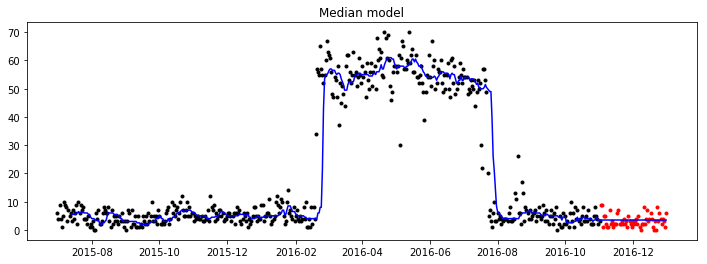

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 0.60069


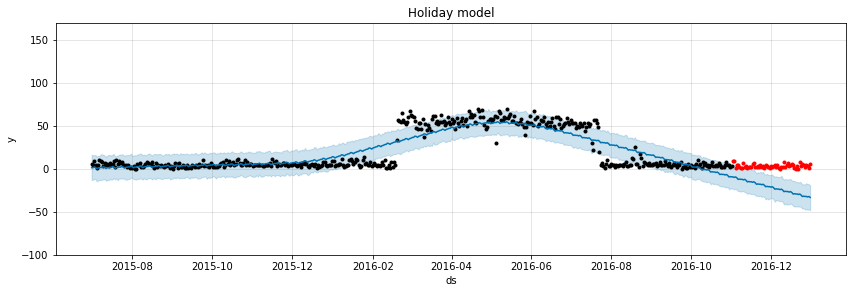

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 1.90000


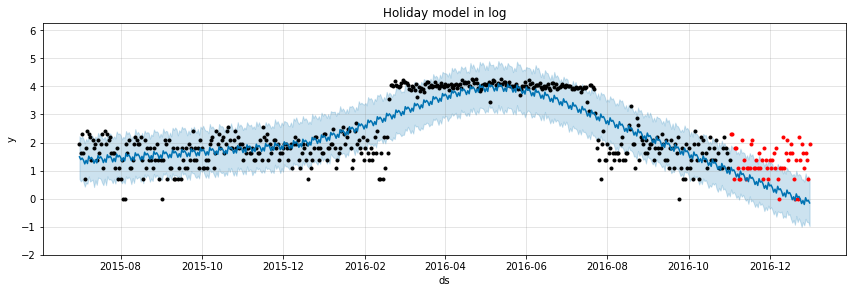

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The SMAPE score is : 1.30013


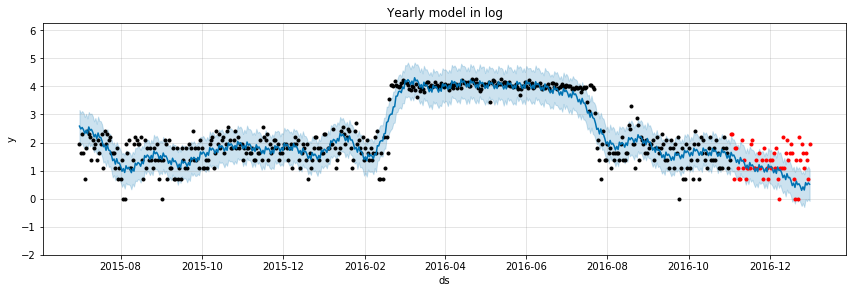

The SMAPE score is : 0.81116


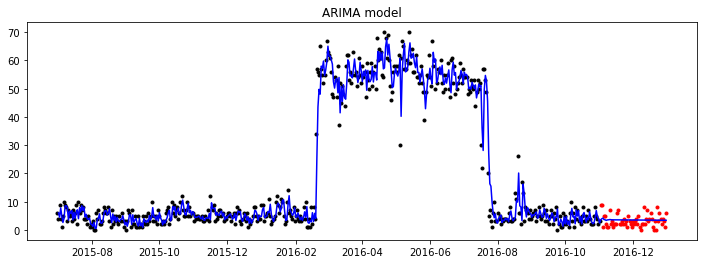

The SMAPE score is : 0.60173


In [89]:
df_train = extract_series(X_train, series_num, 5)
df_actual = extract_series(y_train, series_num, 5)

lang = X_train.iloc[series_num, 1]
title = X_train.iloc[series_num, 4]
print(title)

try:
    score = median_model(df_train.copy(), df_actual.copy(), 14, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating median model", e)

try:
    score = holiday_model(df_train.copy(), df_actual.copy(), review=True,lang = lang)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating holiday model", e)
    
try:
    score = holiday_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating holiday model in log", e)
    
try:
    score = yearly_model_log(df_train.copy(), df_actual.copy(), lang, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating yearly model in log", e)

try:
    score = arima_model(df_train.copy(), df_actual.copy(), 7, 1, 2, review=True)
    print("The SMAPE score is : %.5f" % score)
except Exception as e:
    print("Error in calculating arima model", e)